<a href="https://colab.research.google.com/github/antoniogss/air_quality/blob/main/graphs_cetesb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook imports and packages

In [1]:
#@title
import pandas as pd
import numpy as np
import warnings as war
import google.colab as gc
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from google.colab import files #Upload files into the notebook
from glob import glob
from datetime import date, time, datetime, timedelta
from functools import reduce
from matplotlib import dates, rcParams
from scipy.stats import linregress
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose

war.filterwarnings('ignore')

gc.output.clear()

#Google Drive connection

In [2]:
gc.drive.mount('./gdrive/', 
               force_remount=True
              )
gc.output.clear()

#Setting up the working directory

In [3]:
#@title
%cd ./gdrive/MyDrive/air_quality/datasets/created_datasets/

dir = '/content/gdrive/MyDrive/air_quality/images/'

/content/gdrive/MyDrive/air_quality/datasets/created_datasets


#Load the csv file into a DF

In [138]:
#@title
df = pd.read_csv('df.csv', parse_dates=['data_hora'])
df.drop('Unnamed: 0', axis=1,inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

mes_ptbr = {'January':'Janeiro', 
             'February':'Fevereiro', 
             'March':'Março', 
             'April':'Abril', 
             'May':'Maio', 
             'June':'Junho', 
             'July':'Julho',
             'August':'Agosto', 
             'September':'Setembro',
             'October':'Outubro', 
             'November':'Novembro',
             'December':'Dezembro'}

df['mes'] = df['data_hora'].dt.month_name().replace(mes_ptbr)

df['trimestre'] = df['data_hora'].dt.quarter

df['horas'] = df['data_hora'].dt.hour

df['H'] = 'h'

df['hora_24'] = df['horas'].astype(str) + df['H']

df = df.drop('H', 1)

df['ano'] = df['data_hora'].dt.year

df.loc[(df!=0).any(axis=1)]

df.head()

,O3,RADG,RADUV,estacao,NO,NO2,NOx,TEMP,UR,VV,data_hora,dia_da_semana,mes,trimestre,horas,hora_24,ano
0,NaN,NaN,NaN,Capão Redondo,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01 01:00:00,Domingo,Janeiro,1,1,1h,2012
1,NaN,NaN,NaN,Capão Redondo,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01 02:00:00,Domingo,Janeiro,1,2,2h,2012
2,NaN,NaN,NaN,Capão Redondo,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01 03:00:00,Domingo,Janeiro,1,3,3h,2012
3,NaN,NaN,NaN,Capão Redondo,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01 04:00:00,Domingo,Janeiro,1,4,4h,2012
4,NaN,NaN,NaN,Capão Redondo,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01 05:00:00,Domingo,Janeiro,1,5,5h,2012


#Mapping NaN values

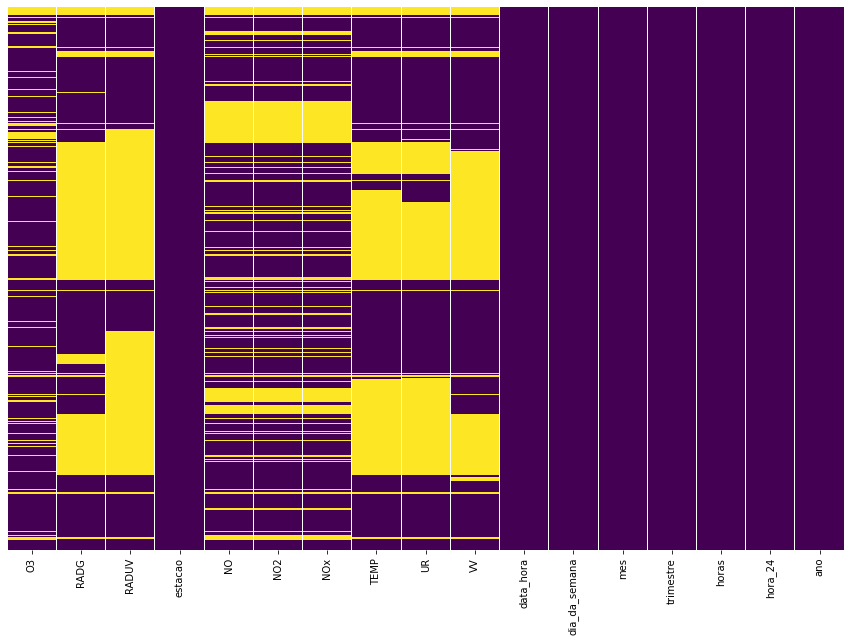

In [139]:
#@title
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='viridis',
            ax=ax
          );

#Null values by column

In [140]:
#@title
df.isnull().sum()

O3                47696
RADG             151866
RADUV            204844
estacao               0
NO                87712
NO2               87719
NOx               87716
TEMP             157397
UR               151048
VV               142675
data_hora             0
dia_da_semana         0
mes                   0
trimestre             0
horas                 0
hora_24               0
ano                   0
dtype: int64

#Percentage of null values 

In [141]:
#O3
# print(round((df['O3'].isna().sum() / len(df['O3']))*100),'%')
print(round((df['O3'].isnull().sum() / df['O3'].notnull().sum())*100),'%')

16 %


In [142]:
#NO
# print(round((df['NO'].isna().sum() / len(df['NO']))*100),'%')
print(round((df['NO'].isnull().sum() / df['NO'].notnull().sum())*100),'%')

33 %


In [143]:
#NO2
# print(round((df['NO2'].isna().sum() / len(df['NO2']))*100),'%')
print(round((df['NO2'].isnull().sum() / df['NO2'].notnull().sum())*100),'%')

33 %


#Counts of unique rows

By 'stacao'

In [144]:
df['estacao'].value_counts()
# df['estacao'].value_counts(normalize=True)

Capão Redondo          87672
Ibirapuera             87672
Interlagos             87672
Parque Dom Pedro II    87672
Name: estacao, dtype: int64

#DFs by estation

##Hourly

In [149]:
columns = ['RADG', 'RADUV', 'estacao', 'NO', 'NO2', 'NOx', 'TEMP', 'UR',
           'VV', 'dia_da_semana', 'mes', 'trimestre', 'horas',
           'hora_24', 'ano']

In [146]:
#Setting 8-hour period

start = 11
stop = 18
horas = list(range(start,stop+1))

###Capão Redondo

In [151]:
##################
#  All the time
##################

filt = df['estacao'] == 'Capão Redondo'
cp_hour = df.loc[filt]
cp_hour['data_hora'] = pd.to_datetime(df['data_hora'])
# cp_hour.head()

##################
#  8-hour period
##################

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_o3_8_hour = df.loc[filt_2]
cp_o3_8_hour['data_hora'] = pd.to_datetime(df['data_hora'])
cp_o3_8_hour = cp_o3_8_hour.drop(columns, axis=1)
# cp_o3_8_hour.head()

###Ibirapuera

In [152]:
##################
#  All the time
##################

filt = df['estacao'] == 'Ibirapuera'
ib_hour = df.loc[filt]
ib_hour['data_hora'] = pd.to_datetime(df['data_hora'])
# ib_hour.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_o3_8_hour = df.loc[filt_2]
ib_o3_8_hour['data_hora'] = pd.to_datetime(df['data_hora'])
ib_o3_8_hour = ib_o3_8_hour.drop(columns, axis=1)
# ib_o3_8_hour.head()

###Interlagos

In [153]:
##################
#  All the time
##################

filt = df['estacao'] == 'Interlagos'
inter_hour = df.loc[filt]
inter_hour['data_hora'] = pd.to_datetime(df['data_hora'])
# inter_hour.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_o3_8_hour = df.loc[filt_2]
inter_o3_8_hour['data_hora'] = pd.to_datetime(df['data_hora'])
inter_o3_8_hour = inter_o3_8_hour.drop(columns, axis=1)
# inter_o3_8_hour.head()

###Parque Dom Pedro II

In [154]:
##################
#  All the time
##################

filt = df['estacao'] == 'Parque Dom Pedro II'
pq_hour = df.loc[filt]
pq_hour['data_hora'] = pd.to_datetime(df['data_hora'])
# pq_hour.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pq_o3_8_hour = df.loc[filt_2]
pq_o3_8_hour['data_hora'] = pd.to_datetime(df['data_hora'])
pq_o3_8_hour = pq_o3_8_hour.drop(columns, axis=1)
# pq_o3_8_hour.head()

##Daily

In [155]:
cols = {'O3' : 'mean', 
        'NO' : 'mean',
        'NO2' : 'mean'}

cols_2 = {'O3' : 'std', 
          'NO' : 'std',
          'NO2' : 'std'}

columns = ['NO', 'NO2', 'dia_da_semana']

dias_ptbr = {'Sunday':'Domingo', 
             'Monday':'Segunda-feira', 
             'Tuesday':'Terça-feira', 
             'Wednesday':'Quarta-feira', 
             'Thursday':'Quinta-feira', 
             'Friday':'Sexta-feira', 
             'Saturday':'Sábado'}

###Capão Redondo

In [156]:
##################
#  All the time
##################

filt = df['estacao'] == 'Capão Redondo'
cp_day = df.loc[filt]
cp_day['data_hora'] = pd.to_datetime(df['data_hora'])
cp_day.set_index('data_hora', inplace = True)
cp_day = cp_day.resample('D').agg(cols)
cp_day.reset_index(inplace=True)
cp_day['dia_da_semana'] = cp_day['data_hora'].dt.day_name().replace(dias_ptbr)
# cp_day.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_o3_8h_day = df.loc[filt_2]
cp_o3_8h_day['data_hora'] = pd.to_datetime(df['data_hora'])
cp_o3_8h_day.set_index('data_hora', inplace = True)
cp_o3_8h_day = cp_o3_8h_day.resample('D').agg(cols)
cp_o3_8h_day.reset_index(inplace=True)
cp_o3_8h_day['dia_da_semana'] = cp_o3_8h_day['data_hora'].dt.day_name().replace(dias_ptbr)
cp_o3_8h_day = cp_o3_8h_day.drop(columns, axis=1)
# cp_o3_8h_day.head()

###Ibirapuera

In [157]:
##################
#  All the time
##################

filt = df['estacao'] == 'Ibirapuera'
ib_day = df.loc[filt]
ib_day['data_hora'] = pd.to_datetime(df['data_hora'])
ib_day.set_index('data_hora', inplace = True)
ib_day = ib_day.resample('D').agg(cols)
ib_day.reset_index(inplace=True)
ib_day['dia_da_semana'] = ib_day['data_hora'].dt.day_name().replace(dias_ptbr)
# ib_day.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_o3_8h_day = df.loc[filt_2]
ib_o3_8h_day['data_hora'] = pd.to_datetime(df['data_hora'])
ib_o3_8h_day.set_index('data_hora', inplace = True)
ib_o3_8h_day = ib_o3_8h_day.resample('D').agg(cols)
ib_o3_8h_day.reset_index(inplace=True)
ib_o3_8h_day['dia_da_semana'] = ib_o3_8h_day['data_hora'].dt.day_name().replace(dias_ptbr)
ib_o3_8h_day = ib_o3_8h_day.drop(columns, axis=1)
# ib_o3_8h_day.head()

###Interlagos

In [158]:
##################
#  All the time
##################

filt = df['estacao'] == 'Interlagos'
inter_day = df.loc[filt]
inter_day['data_hora'] = pd.to_datetime(df['data_hora'])
inter_day.set_index('data_hora', inplace = True)
inter_day = inter_day.resample('D').agg(cols)
inter_day.reset_index(inplace=True)
inter_day['dia_da_semana'] = inter_day['data_hora'].dt.day_name().replace(dias_ptbr)
# inter_day.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_o3_8h_day = df.loc[filt_2]
inter_o3_8h_day['data_hora'] = pd.to_datetime(df['data_hora'])
inter_o3_8h_day.set_index('data_hora', inplace = True)
inter_o3_8h_day = inter_o3_8h_day.resample('D').agg(cols)
inter_o3_8h_day.reset_index(inplace=True)
inter_o3_8h_day['dia_da_semana'] = inter_o3_8h_day['data_hora'].dt.day_name().replace(dias_ptbr)
inter_o3_8h_day = inter_o3_8h_day.drop(columns, axis=1)
# inter_o3_8h_day.head()

###Parque Dom Pedro II

In [159]:
##################
#  All the time
##################

filt = df['estacao'] == 'Parque Dom Pedro II'
pq_day = df.loc[filt]
pq_day['data_hora'] = pd.to_datetime(df['data_hora'])
pq_day.set_index('data_hora', inplace = True)
pq_day = pq_day.resample('D').agg(cols)
pq_day.reset_index(inplace=True)
pq_day['dia_da_semana'] = pq_day['data_hora'].dt.day_name().replace(dias_ptbr)
# pq_day.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pq_o3_8h_day = df.loc[filt_2]
pq_o3_8h_day['data_hora'] = pd.to_datetime(df['data_hora'])
pq_o3_8h_day.set_index('data_hora', inplace = True)
pq_o3_8h_day = pq_o3_8h_day.resample('D').agg(cols)
pq_o3_8h_day.reset_index(inplace=True)
pq_o3_8h_day['dia_da_semana'] = pq_o3_8h_day['data_hora'].dt.day_name().replace(dias_ptbr)
pq_o3_8h_day = pq_o3_8h_day.drop(columns, axis=1)
# pq_o3_8h_day.head()

##Monthly

In [160]:
columns = ['NO', 'NO2', 'mes']

###Capão Redondo

In [161]:
##################
#  All the time
##################

filt = df['estacao'] == 'Capão Redondo'
cp_month = df.loc[filt]
cp_month['data_hora'] = pd.to_datetime(df['data_hora'])
cp_month.set_index('data_hora', inplace = True)
cp_month = cp_month.resample('M').agg(cols)
cp_month.reset_index(inplace=True)
cp_month['mes'] = cp_month['data_hora'].dt.month_name().replace(mes_ptbr)
# cp_month.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_o3_8h_month = df.loc[filt]
cp_o3_8h_month['data_hora'] = pd.to_datetime(df['data_hora'])
cp_o3_8h_month.set_index('data_hora', inplace = True)
cp_o3_8h_month = cp_o3_8h_month.resample('M').agg(cols)
cp_o3_8h_month.reset_index(inplace=True)
cp_o3_8h_month['mes'] = cp_o3_8h_month['data_hora'].dt.month_name().replace(mes_ptbr)
cp_o3_8h_month = cp_o3_8h_month.drop(columns, axis=1)
# cp_o3_8h_month.head()

###Ibirapuera

In [162]:
##################
#  All the time
##################

filt = df['estacao'] == 'Ibirapuera'
ib_month = df.loc[filt]
ib_month['data_hora'] = pd.to_datetime(df['data_hora'])
ib_month.set_index('data_hora', inplace = True)
ib_month = ib_month.resample('M').agg(cols)
ib_month.reset_index(inplace=True)
ib_month['mes'] = ib_month['data_hora'].dt.month_name().replace(mes_ptbr)
# ib_month.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_o3_8h_month = df.loc[filt]
ib_o3_8h_month['data_hora'] = pd.to_datetime(df['data_hora'])
ib_o3_8h_month.set_index('data_hora', inplace = True)
ib_o3_8h_month = ib_o3_8h_month.resample('M').agg(cols)
ib_o3_8h_month.reset_index(inplace=True)
ib_o3_8h_month['mes'] = ib_o3_8h_month['data_hora'].dt.month_name().replace(mes_ptbr)
ib_o3_8h_month = ib_o3_8h_month.drop(columns, axis=1)
# ib_o3_8h_month.head()

###Interlagos

In [163]:
##################
#  All the time
##################

filt = df['estacao'] == 'Interlagos'
inter_month = df.loc[filt]
inter_month['data_hora'] = pd.to_datetime(df['data_hora'])
inter_month.set_index('data_hora', inplace = True)
inter_month = inter_month.resample('M').agg(cols)
inter_month.reset_index(inplace=True)
inter_month['mes'] = inter_month['data_hora'].dt.month_name().replace(mes_ptbr)
# inter_month.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_o3_8h_month = df.loc[filt]
inter_o3_8h_month['data_hora'] = pd.to_datetime(df['data_hora'])
inter_o3_8h_month.set_index('data_hora', inplace = True)
inter_o3_8h_month = inter_o3_8h_month.resample('M').agg(cols)
inter_o3_8h_month.reset_index(inplace=True)
inter_o3_8h_month['mes'] = inter_o3_8h_month['data_hora'].dt.month_name().replace(mes_ptbr)
inter_o3_8h_month = inter_o3_8h_month.drop(columns, axis=1)
# inter_o3_8h_month.head()

###Parque Dom Pedro II

In [164]:
##################
#  All the time
##################

filt = df['estacao'] == 'Parque Dom Pedro II'
pq_month = df.loc[filt]
pq_month['data_hora'] = pd.to_datetime(df['data_hora'])
pq_month.set_index('data_hora', inplace = True)
pq_month = pq_month.resample('M').agg(cols)
pq_month.reset_index(inplace=True)
pq_month['mes'] = pq_month['data_hora'].dt.month_name().replace(mes_ptbr)
# pq_month.head()

##################
#O3 8-hour period
##################

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pq_o3_8h_month = df.loc[filt]
pq_o3_8h_month['data_hora'] = pd.to_datetime(df['data_hora'])
pq_o3_8h_month.set_index('data_hora', inplace = True)
pq_o3_8h_month = pq_o3_8h_month.resample('M').agg(cols)
pq_o3_8h_month.reset_index(inplace=True)
pq_o3_8h_month['mes'] = pq_o3_8h_month['data_hora'].dt.month_name().replace(mes_ptbr)
pq_o3_8h_month = pq_o3_8h_month.drop(columns, axis=1)
# pq_o3_8h_month.head()

##Yearly

In [165]:
year = {'num':list(range(2012,2022))}
year_df = pd.DataFrame(data=year)
year_df['hora'] = year_df['num'].map(str)
year_list = year_df['hora'].tolist()

columns = ['NO', 'NO2']

###Capão Redondo

In [166]:
##################
#  All the time
##################

#################
#      MEAN
#################

filt = df['estacao'] == 'Capão Redondo'
cp_year = df.loc[filt]
cp_year['data_hora'] = pd.to_datetime(df['data_hora'])
cp_year.set_index('data_hora', inplace = True)
cp_year = cp_year.resample('A').agg(cols)
cp_year.reset_index(inplace=True)
cp_year['ano'] = year_list
# cp_year.head()

###########################
#    Standard Deviation
###########################

std_cp_year = df.loc[filt]
std_cp_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_cp_year.set_index('data_hora', inplace = True)
std_cp_year = std_cp_year.resample('A').agg(cols_2)
std_cp_year.reset_index(inplace=True)
std_cp_year['ano'] = year_list
# std_cp_year.head()

##################
#O3 8-hour period
##################

#################
#      MEAN
#################

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_o3_8h_year = df.loc[filt_2]
cp_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
cp_o3_8h_year.set_index('data_hora', inplace = True)
cp_o3_8h_year = cp_o3_8h_year.resample('A').agg(cols)
cp_o3_8h_year.reset_index(inplace=True)
cp_o3_8h_year['ano'] = year_list
cp_o3_8h_year = cp_o3_8h_year.drop(columns, axis=1)
# cp_o3_8h_year.head()

###########################
#    Standard Deviation
###########################

std_cp_o3_8h_year = df.loc[filt_2]
std_cp_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_cp_o3_8h_year.set_index('data_hora', inplace = True)
std_cp_o3_8h_year = std_cp_o3_8h_year.resample('A').agg(cols_2)
std_cp_o3_8h_year.reset_index(inplace=True)
std_cp_o3_8h_year['ano'] = year_list
std_cp_o3_8h_year = std_cp_o3_8h_year.drop(columns, axis=1)
# std_cp_o3_8h_year.head()

###Ibirapuera

In [167]:
##################
#  All the time
##################

#################
#      MEAN
#################

filt = df['estacao'] == 'Ibirapuera'
ib_year = df.loc[filt]
ib_year['data_hora'] = pd.to_datetime(df['data_hora'])
ib_year.set_index('data_hora', inplace = True)
ib_year = ib_year.resample('A').agg(cols)
ib_year.reset_index(inplace=True)
ib_year['ano'] = year_list
# ib_year.head()

###########################
#    Standard Deviation
###########################

std_ib_year = df.loc[filt]
std_ib_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_ib_year.set_index('data_hora', inplace = True)
std_ib_year = std_ib_year.resample('A').agg(cols_2)
std_ib_year.reset_index(inplace=True)
std_ib_year['ano'] = year_list
# std_ib_year.head()

##################
#O3 8-hour period
##################

#################
#      MEAN
#################

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_o3_8h_year = df.loc[filt_2]
ib_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
ib_o3_8h_year.set_index('data_hora', inplace = True)
ib_o3_8h_year = ib_o3_8h_year.resample('A').agg(cols)
ib_o3_8h_year.reset_index(inplace=True)
ib_o3_8h_year['ano'] = year_list
ib_o3_8h_year = ib_o3_8h_year.drop(columns, axis=1)
# ib_o3_8h_year.head()

###########################
#    Standard Deviation
###########################

std_ib_o3_8h_year = df.loc[filt_2]
std_ib_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_ib_o3_8h_year.set_index('data_hora', inplace = True)
std_ib_o3_8h_year = std_ib_o3_8h_year.resample('A').agg(cols_2)
std_ib_o3_8h_year.reset_index(inplace=True)
std_ib_o3_8h_year['ano'] = year_list
std_ib_o3_8h_year = std_ib_o3_8h_year.drop(columns, axis=1)
# std_ib_o3_8h_year.head()

###Interlagos

In [168]:
##################
#  All the time
##################

#################
#      MEAN
#################

filt = df['estacao'] == 'Interlagos'
inter_year = df.loc[filt]
inter_year['data_hora'] = pd.to_datetime(df['data_hora'])
inter_year.set_index('data_hora', inplace = True)
inter_year = inter_year.resample('A').agg(cols)
inter_year.reset_index(inplace=True)
inter_year['ano'] = year_list
# inter_year.head()

###########################
#    Standard Deviation
###########################

std_inter_year = df.loc[filt]
std_inter_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_inter_year.set_index('data_hora', inplace = True)
std_inter_year = std_inter_year.resample('A').agg(cols_2)
std_inter_year.reset_index(inplace=True)
std_inter_year['ano'] = year_list
# std_inter_year.head()

##################
#O3 8-hour period
##################

#################
#      MEAN
#################

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_o3_8h_year = df.loc[filt_2]
inter_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
inter_o3_8h_year.set_index('data_hora', inplace = True)
inter_o3_8h_year = inter_o3_8h_year.resample('A').agg(cols)
inter_o3_8h_year.reset_index(inplace=True)
inter_o3_8h_year['ano'] = year_list
inter_o3_8h_year = inter_o3_8h_year.drop(columns, axis=1)
# inter_o3_8h_year.head()

###########################
#    Standard Deviation
###########################

std_inter_o3_8h_year = df.loc[filt_2]
std_inter_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_inter_o3_8h_year.set_index('data_hora', inplace = True)
std_inter_o3_8h_year = std_inter_o3_8h_year.resample('A').agg(cols_2)
std_inter_o3_8h_year.reset_index(inplace=True)
std_inter_o3_8h_year['ano'] = year_list
std_inter_o3_8h_year = std_inter_o3_8h_year.drop(columns, axis=1)
# std_inter_o3_8h_year.head()

###Parque Dom Pedro II

In [169]:
##################
#  All the time
##################

#################
#      MEAN
#################

filt = df['estacao'] == 'Parque Dom Pedro II'
pq_year = df.loc[filt]
pq_year['data_hora'] = pd.to_datetime(df['data_hora'])
pq_year.set_index('data_hora', inplace = True)
pq_year = pq_year.resample('A').agg(cols)
pq_year.reset_index(inplace=True)
pq_year['ano'] = year_list
# pd_year.head()

###########################
#    Standard Deviation
##########################

std_pq_year = df.loc[filt]
std_pq_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_pq_year.set_index('data_hora', inplace = True)
std_pq_year = std_pq_year.resample('A').agg(cols_2)
std_pq_year.reset_index(inplace=True)
std_pq_year['ano'] = year_list
# std_pq_year.head()

##################
#O3 8-hour period
##################

#################
#      MEAN
#################

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pq_o3_8h_year = df.loc[filt_2]
pq_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
pq_o3_8h_year.set_index('data_hora', inplace = True)
pq_o3_8h_year = pq_o3_8h_year.resample('A').agg(cols)
pq_o3_8h_year.reset_index(inplace=True)
pq_o3_8h_year['ano'] = year_list
pq_o3_8h_year = pq_o3_8h_year.drop(columns, axis=1)
# pq_o3_8h_year.head()

###########################
#    Standard Deviation
###########################

std_pq_o3_8h_year = df.loc[filt_2]
std_pq_o3_8h_year['data_hora'] = pd.to_datetime(df['data_hora'])
std_pq_o3_8h_year.set_index('data_hora', inplace = True)
std_pq_o3_8h_year = std_pq_o3_8h_year.resample('A').agg(cols_2)
std_pq_o3_8h_year.reset_index(inplace=True)
std_pq_o3_8h_year['ano'] = year_list
std_pq_o3_8h_year = std_pq_o3_8h_year.drop(columns, axis=1)
# std_pq_o3_8h_year.head()

#Data Analysis and Graphs

2012-2021

##Day

###Yourly Concentration

In [170]:
#@title
hour = {'num':list(range(0,24)),'h':['h']*24}
hour_df = pd.DataFrame(data=hour)
hour_df['hora'] = hour_df['num'].map(str) + hour_df['h']
hour_df.drop(['num', 'h'], axis = 1, inplace=True)
hour_list = hour_df['hora'].tolist()

###########################
#          MEAN
###########################

#By station

filt = df['estacao'] == 'Capão Redondo'
cp_by_hour = df.loc[filt]
cp_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
cp_by_hour['data_hora'] = cp_by_hour['data_hora'].dt.strftime('%H-%M-%S')
cp_by_hour = cp_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].mean()
cp_by_hour['hora'] = hour_list

# print(cp_by_hour.to_string())

filt = df['estacao'] == 'Ibirapuera'
ib_by_hour = df.loc[filt]
ib_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
ib_by_hour['data_hora'] = ib_by_hour['data_hora'].dt.strftime('%H-%M-%S')
ib_by_hour = ib_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].mean()
ib_by_hour['hora'] = hour_list

# print(ib_by_hour.to_string())

filt = df['estacao'] == 'Interlagos'
inter_by_hour = df.loc[filt]
inter_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
inter_by_hour['data_hora'] = inter_by_hour['data_hora'].dt.strftime('%H-%M-%S')
inter_by_hour = inter_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].mean()
inter_by_hour['hora'] = hour_list

# print(inter_by_hour.to_string())

filt = df['estacao'] == 'Parque Dom Pedro II'
pd_by_hour = df.loc[filt]
pd_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
pd_by_hour['data_hora'] = pd_by_hour['data_hora'].dt.strftime('%H-%M-%S')
pd_by_hour = pd_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].mean()
pd_by_hour['hora'] = hour_list

# print(pd_by_hour.to_string())

#General

# hour = df
# hour['data_hora'] = pd.to_datetime(df['data_hora'])
# hour['data_hora'] = hour['data_hora'].dt.strftime('%H-%M-%S')
# hour = hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].mean()
# hour['hora'] = hour_list

# print(hour.to_string()) 

###########################
#    Standard Deviation
###########################

#By station

filt = df['estacao'] == 'Capão Redondo'
std_cp_by_hour = df.loc[filt]
std_cp_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
std_cp_by_hour['data_hora'] = std_cp_by_hour['data_hora'].dt.strftime('%H-%M-%S')
std_cp_by_hour = std_cp_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].std()
std_cp_by_hour['hora'] = hour_list

# print(std_cp_by_hour.to_string())

filt = df['estacao'] == 'Ibirapuera'
std_ib_by_hour = df.loc[filt]
std_ib_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
std_ib_by_hour['data_hora'] = std_ib_by_hour['data_hora'].dt.strftime('%H-%M-%S')
std_ib_by_hour = std_ib_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].std()
std_ib_by_hour['hora'] = hour_list

# print(std_ib_by_hour.to_string())

filt = df['estacao'] == 'Interlagos'
std_inter_by_hour = df.loc[filt]
std_inter_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
std_inter_by_hour['data_hora'] = std_inter_by_hour['data_hora'].dt.strftime('%H-%M-%S')
std_inter_by_hour = std_inter_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].std()
std_inter_by_hour['hora'] = hour_list

# print(std_inter_by_hour.to_string())

filt = df['estacao'] == 'Parque Dom Pedro II'
std_pd_by_hour = df.loc[filt]
std_pd_by_hour['data_hora'] = pd.to_datetime(df['data_hora'])
std_pd_by_hour['data_hora'] = std_pd_by_hour['data_hora'].dt.strftime('%H-%M-%S')
std_pd_by_hour = std_pd_by_hour.groupby(['data_hora'])['O3', 'NO', 'NO2'].std()
std_pd_by_hour['hora'] = hour_list

# print(std_pd_by_hour.to_string())

####O3

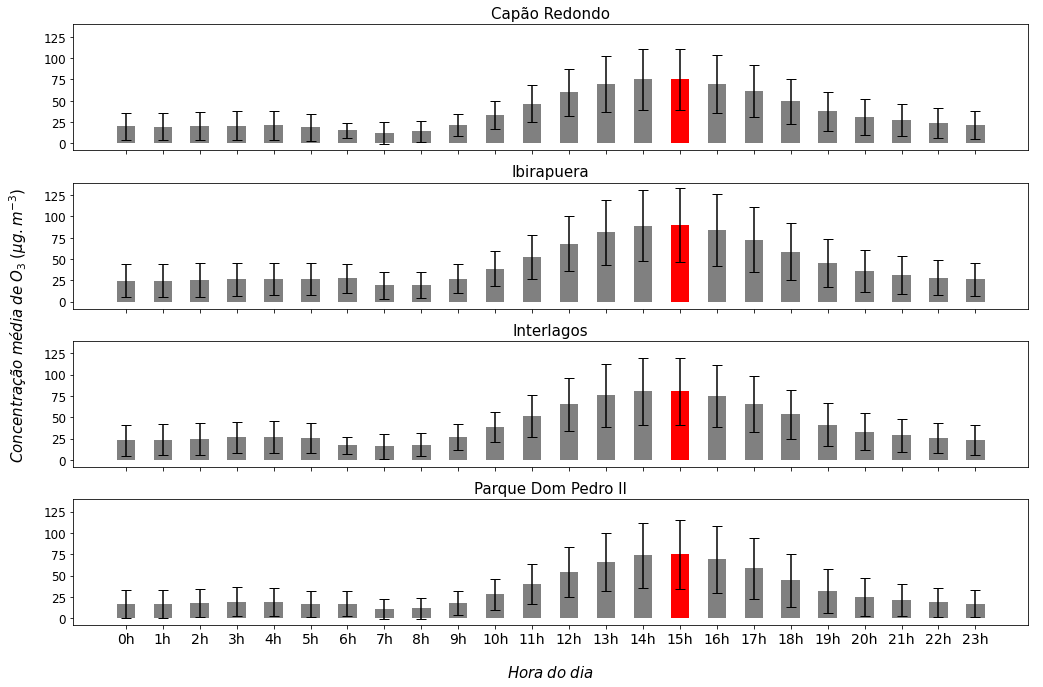

In [171]:
#@title
x_cp_year = cp_by_hour['hora']
x_ib_year = ib_by_hour['hora']
x_inter_year = inter_by_hour['hora']
x_pd_year = pd_by_hour['hora']

y_cp_year_o3 = cp_by_hour['O3']
y_ib_year_o3 = ib_by_hour['O3']
y_inter_year_o3 = inter_by_hour['O3']
y_pd_year_o3 = pd_by_hour['O3']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_o3)) 
              else 'grey' for bar in y_cp_year_o3]

color_2 = ['r' if (bar == max(y_ib_year_o3)) 
              else 'grey' for bar in y_ib_year_o3]    

color_3 = ['r' if (bar == max(y_inter_year_o3)) 
              else 'grey' for bar in y_inter_year_o3]  

color_4 = ['r' if (bar == max(y_pd_year_o3)) 
              else 'grey' for bar in y_pd_year_o3]        

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_o3,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_hour['O3'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_o3, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_hour['O3'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_o3, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_hour['O3'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_o3, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_hour['O3'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Hora\;do\;dia$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'o3_media_hora.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500       
            )

plt.show()

#####Boxplot

In [172]:
#@title
num_int = list(range(0,24))
num_str = map(str, num_int) 
h = list('h'*24)

# using list comprehension + zip()
# interlist element concatenation
hour = [i + j for i, j in zip(num_str, h)]

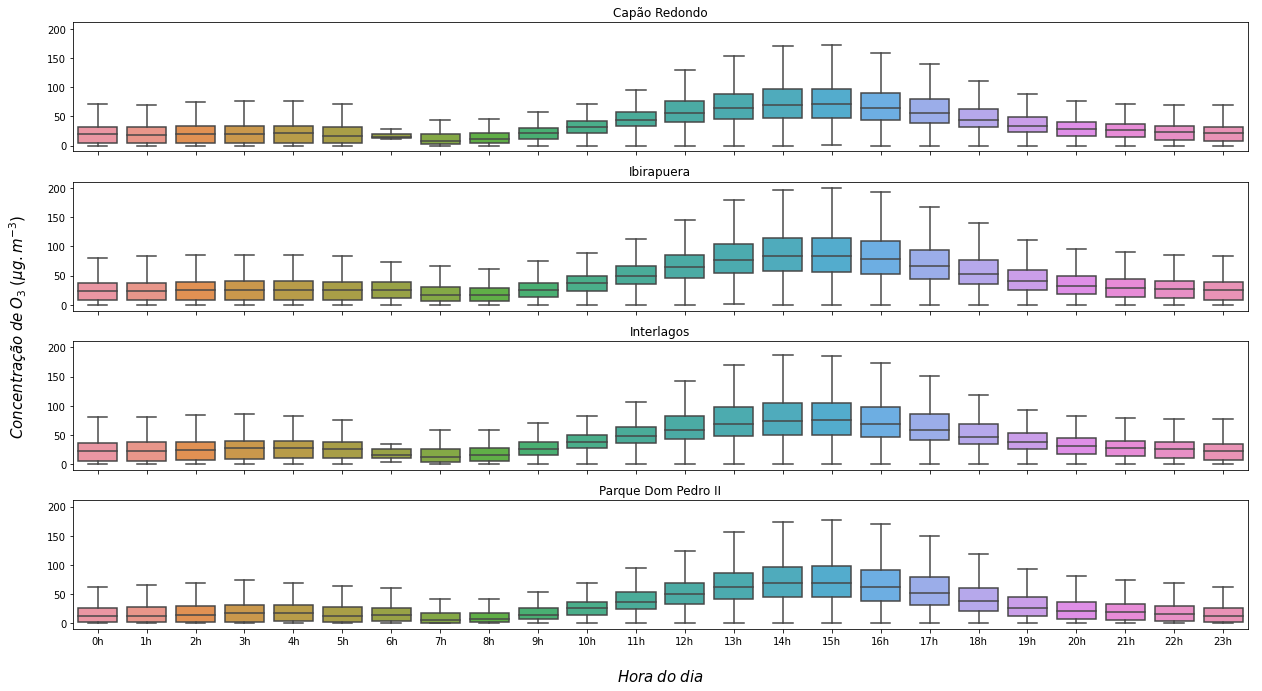

In [173]:
#@title
fig, axes = plt.subplots(nrows=4, 
                         ncols=1, 
                         sharex=True,
                         sharey=True, 
                         figsize=(18,10)
                        )

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], data=df.loc[df.estacao == 'Capão Redondo'], 
            x='hora_24', y='O3', 
            showfliers = False, 
            order = hour
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='hora_24', y='O3', 
            showfliers = False, 
            order = hour
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='hora_24', y='O3', 
            showfliers = False, 
            order = hour
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='hora_24', y='O3', 
            showfliers = False, 
            order = hour
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Hora\;do\;dia$",fontsize=15)
plt.ylabel("$Concentração\;de\;O_{3}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'o3_boxplot_hora_do_dia.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO

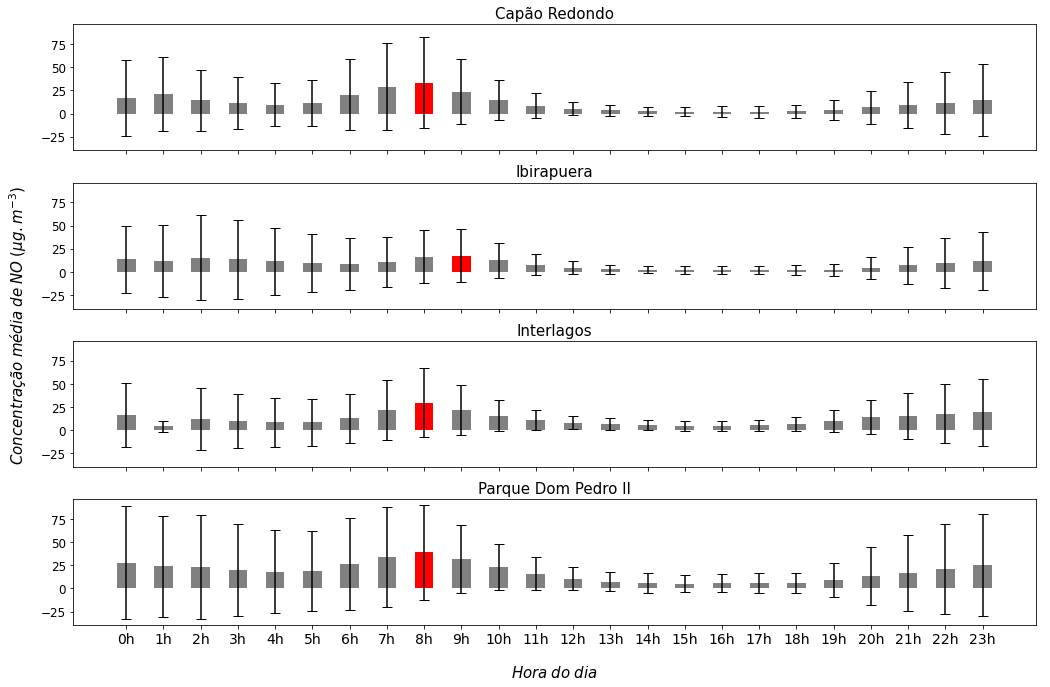

In [174]:
#@title
x_cp_year = cp_by_hour['hora']
x_ib_year = ib_by_hour['hora']
x_inter_year = inter_by_hour['hora']
x_pd_year = pd_by_hour['hora']

y_cp_year_no = cp_by_hour['NO']
y_ib_year_no = ib_by_hour['NO']
y_inter_year_no = inter_by_hour['NO']
y_pd_year_no = pd_by_hour['NO']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no)) 
              else 'grey' for bar in y_cp_year_no]

color_2 = ['r' if (bar == max(y_ib_year_no)) 
              else 'grey' for bar in y_ib_year_no]    

color_3 = ['r' if (bar == max(y_inter_year_no)) 
              else 'grey' for bar in y_inter_year_no]  

color_4 = ['r' if (bar == max(y_pd_year_no)) 
              else 'grey' for bar in y_pd_year_no]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_hour['NO'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_hour['NO'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_hour['NO'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_hour['NO'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False,
              )

plt.xlabel("\n$Hora\;do\;dia$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no_media_hora.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

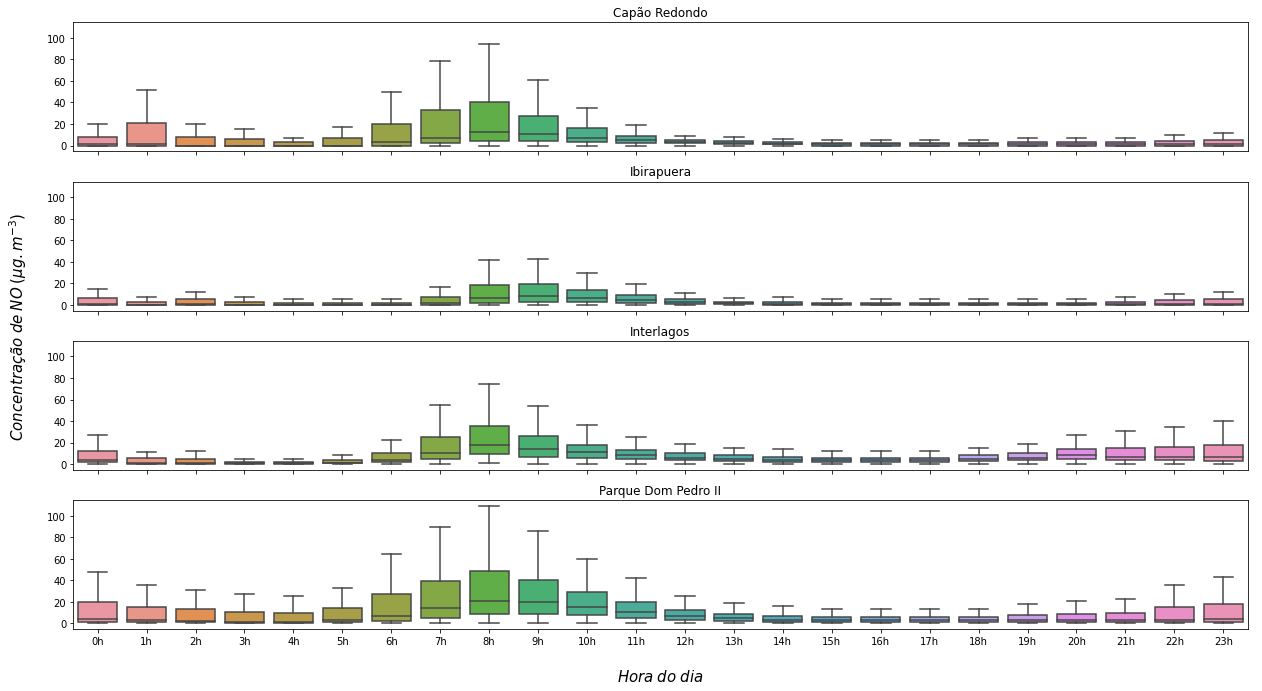

In [175]:
#@title
fig, axes = plt.subplots(nrows=4, 
                         ncols=1, 
                         sharex=True,
                         sharey=True, 
                         figsize=(18,10)
                        )

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], data=df.loc[df.estacao == 'Capão Redondo'], 
            x='hora_24', y='NO', 
            showfliers = False, 
            order = hour
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='hora_24', y='NO', 
            showfliers = False, 
            order = hour
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='hora_24', y='NO', 
            showfliers = False, 
            order = hour
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='hora_24', y='NO', 
            showfliers = False, 
            order = hour
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Hora\;do\;dia$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no_boxplot_hora_do_dia.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO2

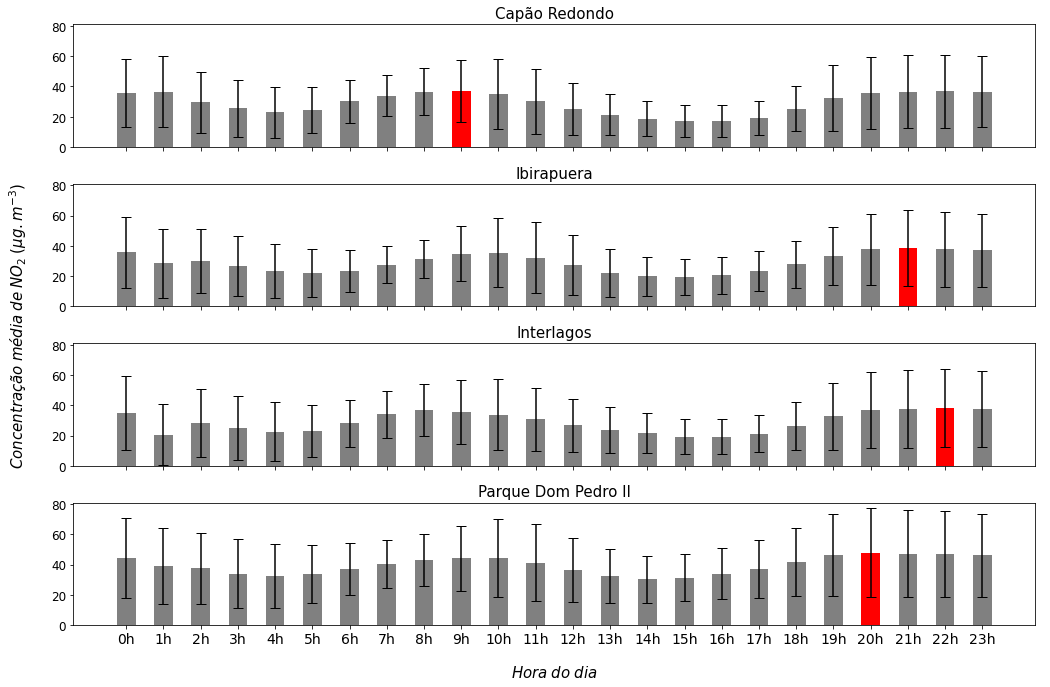

In [176]:
#@title
x_cp_year = cp_by_hour['hora']
x_ib_year = ib_by_hour['hora']
x_inter_year = inter_by_hour['hora']
x_pd_year = pd_by_hour['hora']

y_cp_year_no2 = cp_by_hour['NO2']
y_ib_year_no2 = ib_by_hour['NO2']
y_inter_year_no2 = inter_by_hour['NO2']
y_pd_year_no2 = pd_by_hour['NO2']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no2)) 
              else 'grey' for bar in y_cp_year_no2]

color_2 = ['r' if (bar == max(y_ib_year_no2)) 
              else 'grey' for bar in y_ib_year_no2]    

color_3 = ['r' if (bar == max(y_inter_year_no2)) 
              else 'grey' for bar in y_inter_year_no2]  

color_4 = ['r' if (bar == max(y_pd_year_no2)) 
              else 'grey' for bar in y_pd_year_no2]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no2,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_hour['NO2'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no2, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_hour['NO2'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no2, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_hour['NO2'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no2, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_hour['NO2'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Hora\;do\;dia$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no2_media_hora.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

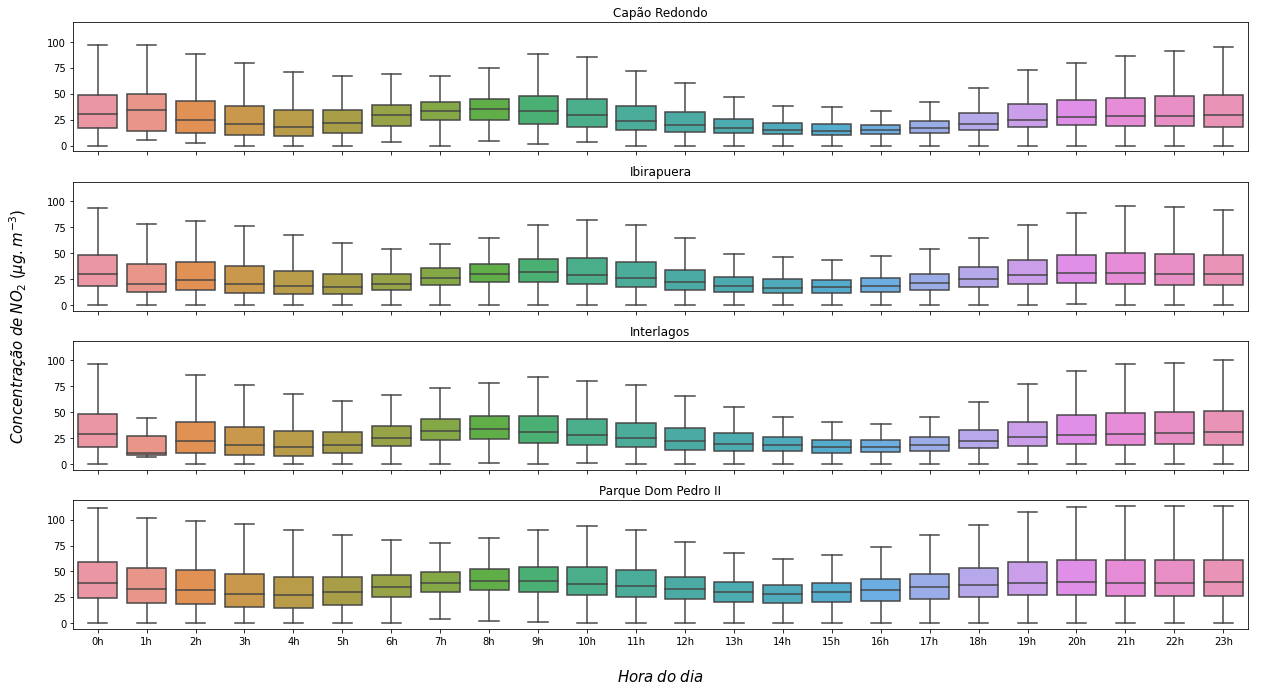

In [177]:
#@title
fig, axes = plt.subplots(nrows=4, 
                         ncols=1, 
                         sharex=True,
                         sharey=True, 
                         figsize=(18,10)
                        )

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], data=df.loc[df.estacao == 'Capão Redondo'], 
            x='hora_24', y='NO2', 
            showfliers = False, 
            order = hour
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='hora_24', y='NO2', 
            showfliers = False, 
            order = hour
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='hora_24', y='NO2', 
            showfliers = False, 
            order = hour
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='hora_24', y='NO2', 
            showfliers = False, 
            order = hour
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Hora\;do\;dia$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO_{2}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no2_boxplot_hora_do_dia.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Mean concentration for each day of the week

In [179]:
#@title
lst = ['Domingo','Segunda-feira','Terça-feira','Quarta-feira', 
       'Quinta-feira','Sexta-feira','Sábado']

#####################
#      MEAN
#####################

filt_1 = df['estacao'] == 'Capão Redondo'
cp_by_week_day_1 = df.loc[filt_1]
cp_by_week_day_1 = cp_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].mean()
cp_by_week_day_1 = cp_by_week_day_1.loc[lst]
cp_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_by_week_day_2 = df.loc[filt_2]
cp_by_week_day_2 = cp_by_week_day_2.groupby(['dia_da_semana'])['O3'].mean()
cp_by_week_day_2 = cp_by_week_day_2.loc[lst]
cp_by_week_day_2 = pd.DataFrame(data=cp_by_week_day_2)

cp_by_week_day = cp_by_week_day_1.merge(cp_by_week_day_2, 
                                        left_on='dia_da_semana', 
                                        right_on='dia_da_semana')

# print(cp_by_week_day.to_string())

filt_1 = df['estacao'] == 'Ibirapuera'
ib_by_week_day_1 = df.loc[filt_1]
ib_by_week_day_1 = ib_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].mean()
ib_by_week_day_1 = ib_by_week_day_1.loc[lst]
ib_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_by_week_day_2 = df.loc[filt_2]
ib_by_week_day_2 = ib_by_week_day_2.groupby(['dia_da_semana'])['O3'].mean()
ib_by_week_day_2 = ib_by_week_day_2.loc[lst]
ib_by_week_day_2 = pd.DataFrame(data=ib_by_week_day_2)

ib_by_week_day = ib_by_week_day_1.merge(ib_by_week_day_2, 
                                        left_on='dia_da_semana', 
                                        right_on='dia_da_semana')

# print(ib_by_week_day.to_string())

filt_1 = df['estacao'] == 'Interlagos'
inter_by_week_day_1 = df.loc[filt_1]
inter_by_week_day_1 = inter_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].mean()
inter_by_week_day_1 = inter_by_week_day_1.loc[lst]
inter_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_by_week_day_2 = df.loc[filt_2]
inter_by_week_day_2 = inter_by_week_day_2.groupby(['dia_da_semana'])['O3'].mean()
inter_by_week_day_2 = inter_by_week_day_2.loc[lst]
inter_by_week_day_2 = pd.DataFrame(data=inter_by_week_day_2)

inter_by_week_day = inter_by_week_day_1.merge(inter_by_week_day_2, 
                                              left_on='dia_da_semana', 
                                              right_on='dia_da_semana')

# print(inter_by_week_day.to_string())

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
pd_by_week_day_1 = df.loc[filt_1]
pd_by_week_day_1 = pd_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].mean()
pd_by_week_day_1 = pd_by_week_day_1.loc[lst]
pd_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pd_by_week_day_2 = df.loc[filt_2]
pd_by_week_day_2 = pd_by_week_day_2.groupby(['dia_da_semana'])['O3'].mean()
pd_by_week_day_2 = pd_by_week_day_2.loc[lst]
pd_by_week_day_2 = pd.DataFrame(data=pd_by_week_day_2)

pd_by_week_day = pd_by_week_day_1.merge(pd_by_week_day_2, 
                                        left_on='dia_da_semana', 
                                        right_on='dia_da_semana')

# print(pd_by_week_day.to_string())

#########################
#   Standard Deviation
#########################


filt_1 = df['estacao'] == 'Capão Redondo'
std_cp_by_week_day_1 = df.loc[filt_1]
std_cp_by_week_day_1 = std_cp_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].std()
std_cp_by_week_day_1 = std_cp_by_week_day_1.loc[lst]
std_cp_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
std_cp_by_week_day_2 = df.loc[filt_2]
std_cp_by_week_day_2 = std_cp_by_week_day_2.groupby(['dia_da_semana'])['O3'].std()
std_cp_by_week_day_2 = std_cp_by_week_day_2.loc[lst]
std_cp_by_week_day_2 = pd.DataFrame(data=std_cp_by_week_day_2)

std_cp_by_week_day = std_cp_by_week_day_1.merge(std_cp_by_week_day_2, 
                                                left_on='dia_da_semana', 
                                                right_on='dia_da_semana')

# print(std_cp_by_week_day.to_string())

filt_1 = df['estacao'] == 'Ibirapuera'
std_ib_by_week_day_1 = df.loc[filt_1]
std_ib_by_week_day_1 = std_ib_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].std()
std_ib_by_week_day_1 = std_ib_by_week_day_1.loc[lst]
std_ib_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
std_ib_by_week_day_2 = df.loc[filt_2]
std_ib_by_week_day_2 = std_ib_by_week_day_2.groupby(['dia_da_semana'])['O3'].std()
std_ib_by_week_day_2 = std_ib_by_week_day_2.loc[lst]
std_ib_by_week_day_2 = pd.DataFrame(data=std_ib_by_week_day_2)

std_ib_by_week_day = std_ib_by_week_day_1.merge(std_ib_by_week_day_2, 
                                                left_on='dia_da_semana', 
                                                right_on='dia_da_semana')

# print(std_ib_by_week_day.to_string())

filt_1 = df['estacao'] == 'Interlagos'
std_inter_by_week_day_1 = df.loc[filt_1]
std_inter_by_week_day_1 = std_inter_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].std()
std_inter_by_week_day_1 = std_inter_by_week_day_1.loc[lst]
std_inter_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
std_inter_by_week_day_2 = df.loc[filt_2]
std_inter_by_week_day_2 = std_inter_by_week_day_2.groupby(['dia_da_semana'])['O3'].std()
std_inter_by_week_day_2 = std_inter_by_week_day_2.loc[lst]
std_inter_by_week_day_2 = pd.DataFrame(data=std_inter_by_week_day_2)

std_inter_by_week_day = std_inter_by_week_day_1.merge(std_inter_by_week_day_2, 
                                                      left_on='dia_da_semana', 
                                                      right_on='dia_da_semana')

# print(std_inter_by_week_day.to_string())

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
std_pd_by_week_day_1 = df.loc[filt_1]
std_pd_by_week_day_1 = std_pd_by_week_day_1.groupby(['dia_da_semana'])['NO', 'NO2'].std()
std_pd_by_week_day_1 = std_pd_by_week_day_1.loc[lst]
std_pd_by_week_day_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
std_pd_by_week_day_2 = df.loc[filt_2]
std_pd_by_week_day_2 = std_pd_by_week_day_2.groupby(['dia_da_semana'])['O3'].std()
std_pd_by_week_day_2 = std_pd_by_week_day_2.loc[lst]
std_pd_by_week_day_2 = pd.DataFrame(data=std_pd_by_week_day_2)

std_pd_by_week_day = std_pd_by_week_day_1.merge(std_pd_by_week_day_2, 
                                                left_on='dia_da_semana', 
                                                right_on='dia_da_semana')

# print(std_pd_by_week_day.to_string())

####O3

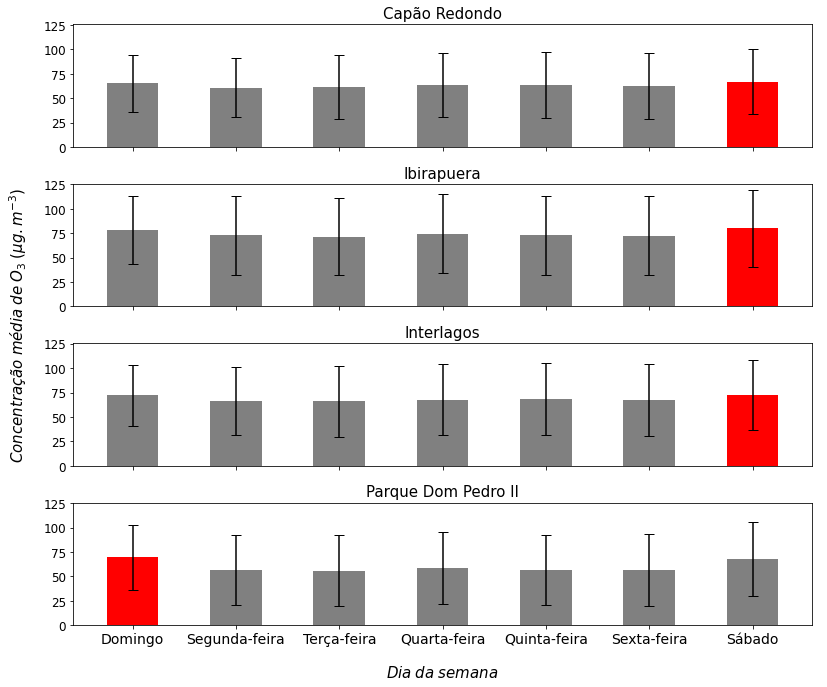

In [180]:
#@title
x_cp_year = cp_by_week_day['dia_da_semana']
x_ib_year = ib_by_week_day['dia_da_semana']
x_inter_year = inter_by_week_day['dia_da_semana']
x_pd_year = pd_by_week_day['dia_da_semana']

y_cp_year_o3 = cp_by_week_day['O3']
y_ib_year_o3 = ib_by_week_day['O3']
y_inter_year_o3 = inter_by_week_day['O3']
y_pd_year_o3 = pd_by_week_day['O3']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_o3)) 
              else 'grey' for bar in y_cp_year_o3]

color_2 = ['r' if (bar == max(y_ib_year_o3)) 
              else 'grey' for bar in y_ib_year_o3]    

color_3 = ['r' if (bar == max(y_inter_year_o3)) 
              else 'grey' for bar in y_inter_year_o3]  

color_4 = ['r' if (bar == max(y_pd_year_o3)) 
              else 'grey' for bar in y_pd_year_o3]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(12,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_o3,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_week_day['O3'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_o3, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_week_day['O3'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_o3, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_week_day['O3'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_o3, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_week_day['O3'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Dia\;da\;semana$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'o3_media_dia_da_semana.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

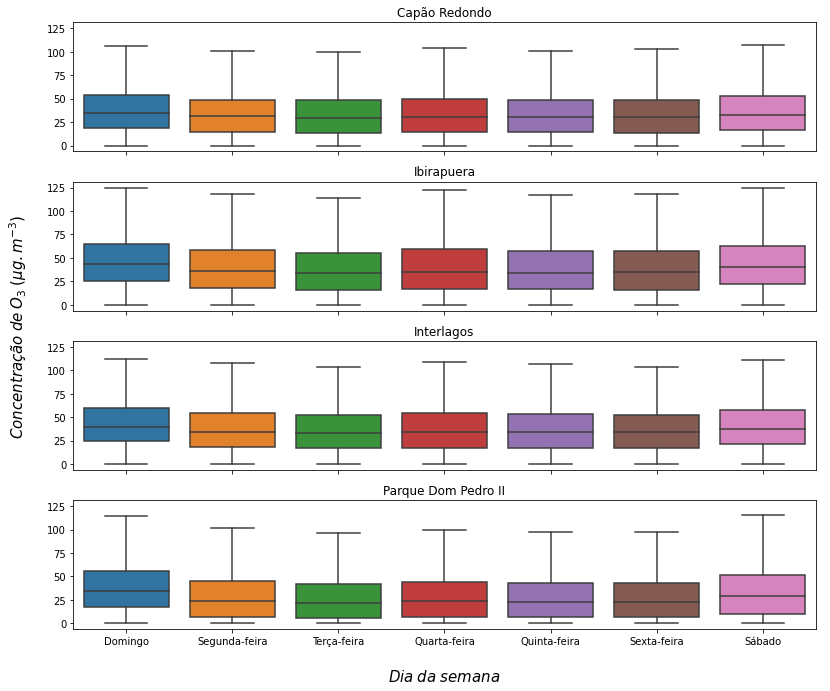

In [181]:
#@title
fig, axes = plt.subplots(nrows=4, 
                         ncols=1, 
                         sharex=True,
                         sharey=True, 
                         figsize=(12,10)
                        )

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], data=df.loc[df.estacao == 'Capão Redondo'], 
            x='dia_da_semana', y='O3', 
            showfliers = False, 
            order = week
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='dia_da_semana', y='O3', 
            showfliers = False, 
            order = week
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='dia_da_semana', y='O3', 
            showfliers = False, 
            order = week
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='dia_da_semana', y='O3', 
            showfliers = False, 
            order = week
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Dia\;da\;semana$",fontsize=15)
plt.ylabel("$Concentração\;de\;O_{3}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'o3_boxplot_dia_da_semana.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO

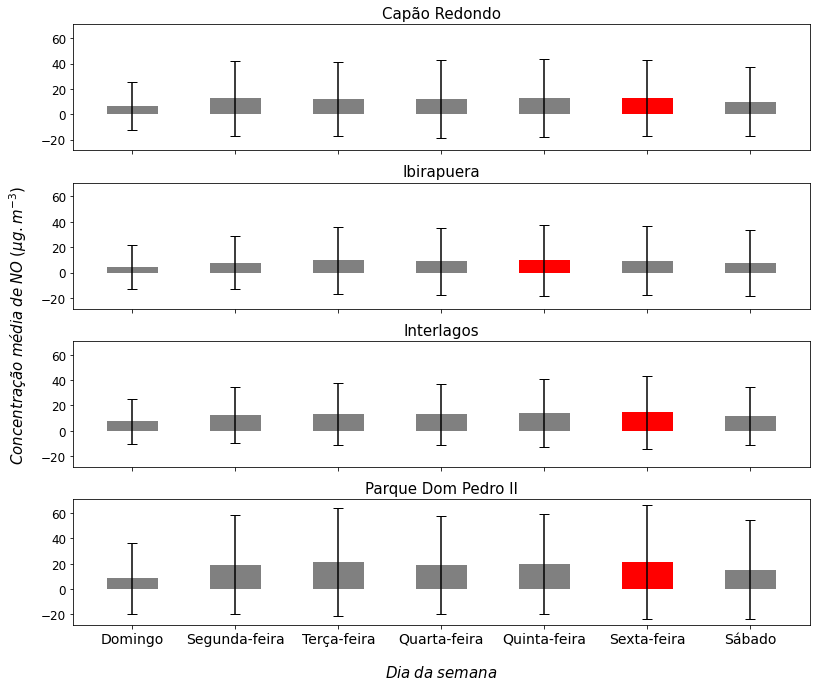

In [182]:
#@title
x_cp_year = cp_by_week_day['dia_da_semana']
x_ib_year = ib_by_week_day['dia_da_semana']
x_inter_year = inter_by_week_day['dia_da_semana']
x_pd_year = pd_by_week_day['dia_da_semana']

y_cp_year_no = cp_by_week_day['NO']
y_ib_year_no = ib_by_week_day['NO']
y_inter_year_no = inter_by_week_day['NO']
y_pd_year_no = pd_by_week_day['NO']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no)) 
              else 'grey' for bar in y_cp_year_no]

color_2 = ['r' if (bar == max(y_ib_year_no)) 
              else 'grey' for bar in y_ib_year_no]    

color_3 = ['r' if (bar == max(y_inter_year_no)) 
              else 'grey' for bar in y_inter_year_no]  

color_4 = ['r' if (bar == max(y_pd_year_no)) 
              else 'grey' for bar in y_pd_year_no]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(12,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_week_day['NO'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_week_day['NO'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_week_day['NO'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_week_day['NO'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Dia\;da\;semana$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no_media_dia_da_semana.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

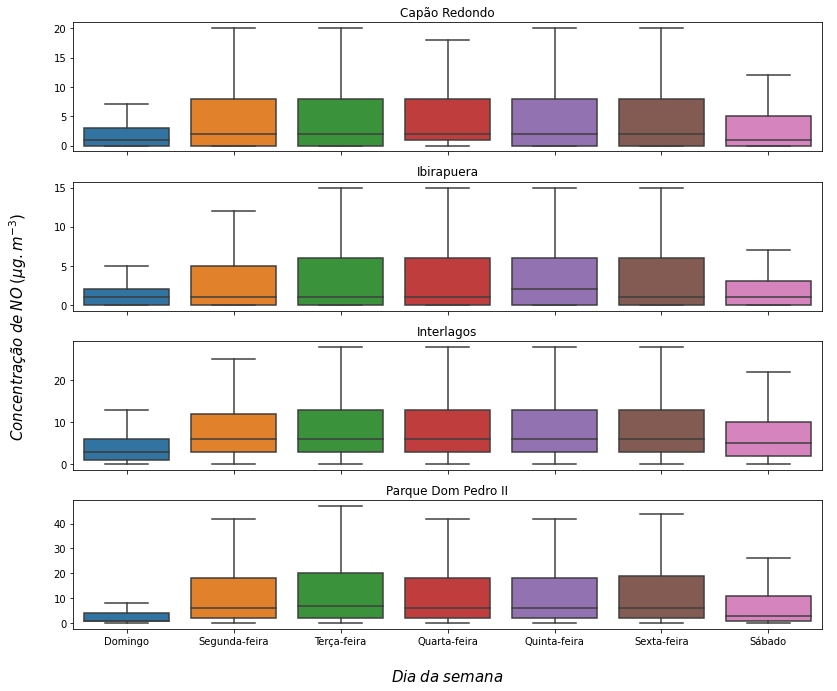

In [183]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='dia_da_semana', y='NO', 
            showfliers = False, 
            order = week
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1],
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='dia_da_semana', y='NO', 
            showfliers = False, 
            order = week
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None) 
g2.set(ylabel=None) 

g3 = sns.boxplot(ax=axes[2],
            data=df.loc[df.estacao == 'Interlagos'], 
            x='dia_da_semana', y='NO', 
            showfliers = False, 
            order = week
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='dia_da_semana', y='NO', 
            showfliers = False, 
            order = week
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel='Dias da semana')
g4.set(xlabel=None)
g4.set(ylabel=None)


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Dia\;da\;semana$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no_boxplot_dia_da_semana.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO2

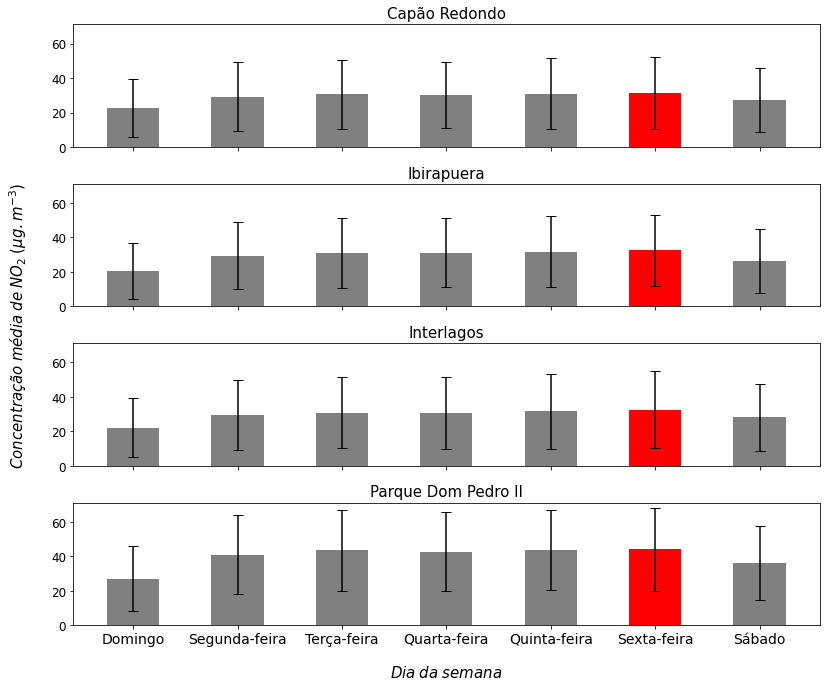

In [184]:
#@title
x_cp_year = cp_by_week_day['dia_da_semana']
x_ib_year = ib_by_week_day['dia_da_semana']
x_inter_year = inter_by_week_day['dia_da_semana']
x_pd_year = pd_by_week_day['dia_da_semana']

y_cp_year_no2 = cp_by_week_day['NO2']
y_ib_year_no2 = ib_by_week_day['NO2']
y_inter_year_no2 = inter_by_week_day['NO2']
y_pd_year_no2 = pd_by_week_day['NO2']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no2)) 
              else 'grey' for bar in y_cp_year_no2]

color_2 = ['r' if (bar == max(y_ib_year_no2)) 
              else 'grey' for bar in y_ib_year_no2]    

color_3 = ['r' if (bar == max(y_inter_year_no2)) 
              else 'grey' for bar in y_inter_year_no2]  

color_4 = ['r' if (bar == max(y_pd_year_no2)) 
              else 'grey' for bar in y_pd_year_no2]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(12,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no2,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_week_day['NO2'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no2, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_week_day['NO2'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no2, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_week_day['NO2'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no2, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_week_day['NO2'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Dia\;da\;semana$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no2_media_dia_da_semana.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

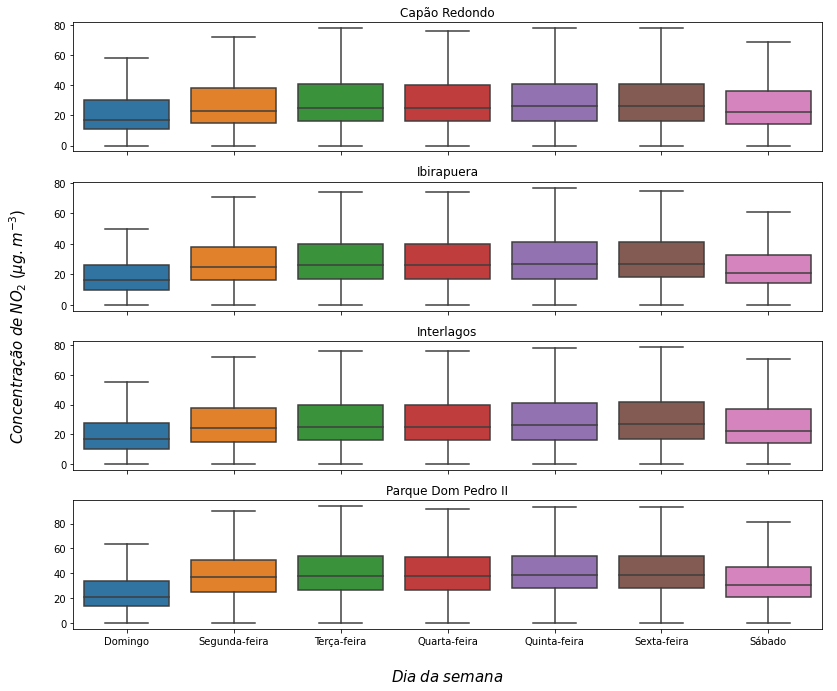

In [185]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], data=df.loc[df.estacao == 'Capão Redondo'], 
            x='dia_da_semana', y='NO2', 
            showfliers = False, 
            order = week
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='dia_da_semana', y='NO2', 
            showfliers = False, 
            order = week
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None) 
g2.set(ylabel=None) 

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='dia_da_semana', y='NO2', 
            showfliers = False, 
            order = week
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='dia_da_semana', y='NO2', 
            showfliers = False, 
            order = week
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Dia\;da\;semana$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO_{2}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no2_boxplot_dia_da_semana.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Mean concentration for each month of the year

In [187]:
#@title
# df['mes'] = df['data_hora'].dt.month_name().replace(mes_ptbr)

lst = ['Janeiro','Fevereiro','Março','Abril', 
       'Maio','Junho','Julho','Agosto',
       'Setembro','Outubro','Novembro', 'Dezembro']

#####################
#        MEAN
#####################

filt_1 = df['estacao'] == 'Capão Redondo'
cp_by_month_year_1 = df.loc[filt_1]
cp_by_month_year_1 = cp_by_month_year_1.groupby(['mes'])['NO', 'NO2'].mean()
cp_by_month_year_1 = cp_by_month_year_1.loc[lst]
cp_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_by_month_year_2 = df.loc[filt_2]
cp_by_month_year_2 = cp_by_month_year_2.groupby(['mes'])['O3'].mean()
cp_by_month_year_2 = cp_by_month_year_2.loc[lst]
cp_by_month_year_2 = pd.DataFrame(data=cp_by_month_year_2)

cp_by_month_year = cp_by_month_year_1.merge(cp_by_month_year_2, left_on='mes', right_on='mes')

# print(cp_by_month_year.to_string())

filt_1 = df['estacao'] == 'Ibirapuera'
ib_by_month_year_1 = df.loc[filt_1]
ib_by_month_year_1 = ib_by_month_year_1.groupby(['mes'])['NO', 'NO2'].mean()
ib_by_month_year_1 = ib_by_month_year_1.loc[lst]
ib_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_by_month_year_2 = df.loc[filt_2]
ib_by_month_year_2 = ib_by_month_year_2.groupby(['mes'])['O3'].mean()
ib_by_month_year_2 = ib_by_month_year_2.loc[lst]
ib_by_month_year_2 = pd.DataFrame(data=ib_by_month_year_2)

ib_by_month_year = ib_by_month_year_1.merge(ib_by_month_year_2, left_on='mes', right_on='mes')

# print(ib_by_month_year.to_string())

filt_1 = df['estacao'] == 'Interlagos'
inter_by_month_year_1 = df.loc[filt_1]
inter_by_month_year_1 = inter_by_month_year_1.groupby(['mes'])['NO', 'NO2'].mean()
inter_by_month_year_1 = inter_by_month_year_1.loc[lst]
inter_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_by_month_year_2 = df.loc[filt_2]
inter_by_month_year_2 = inter_by_month_year_2.groupby(['mes'])['O3'].mean()
inter_by_month_year_2 = inter_by_month_year_2.loc[lst]
inter_by_month_year_2 = pd.DataFrame(data=inter_by_month_year_2)

inter_by_month_year = inter_by_month_year_1.merge(inter_by_month_year_2, left_on='mes', right_on='mes')

# print(inter_by_month_year.to_string())

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
pd_by_month_year_1 = df.loc[filt_1]
pd_by_month_year_1 = pd_by_month_year_1.groupby(['mes'])['NO', 'NO2'].mean()
pd_by_month_year_1 = pd_by_month_year_1.loc[lst]
pd_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pd_by_month_year_2 = df.loc[filt_2]
pd_by_month_year_2 = pd_by_month_year_2.groupby(['mes'])['O3'].mean()
pd_by_month_year_2 = pd_by_month_year_2.loc[lst]
pd_by_month_year_2 = pd.DataFrame(data=pd_by_month_year_2)

pd_by_month_year = pd_by_month_year_1.merge(pd_by_month_year_2, left_on='mes', right_on='mes')

# print(pd_by_month_year.to_string())

#########################
#   Standard Deviation
#########################

filt_1 = df['estacao'] == 'Capão Redondo'
std_cp_by_month_year_1 = df.loc[filt_1]
std_cp_by_month_year_1 = std_cp_by_month_year_1.groupby(['mes'])['NO', 'NO2'].std()
std_cp_by_month_year_1 = std_cp_by_month_year_1.loc[lst]
std_cp_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
std_cp_by_month_year_2 = df.loc[filt_2]
std_cp_by_month_year_2 = std_cp_by_month_year_2.groupby(['mes'])['O3'].std()
std_cp_by_month_year_2 = std_cp_by_month_year_2.loc[lst]
std_cp_by_month_year_2 = pd.DataFrame(data=std_cp_by_month_year_2)

std_cp_by_month_year = std_cp_by_month_year_1.merge(std_cp_by_month_year_2, left_on='mes', right_on='mes')

# print(std_cp_by_month_year.to_string())

filt_1 = df['estacao'] == 'Ibirapuera'
std_ib_by_month_year_1 = df.loc[filt_1]
std_ib_by_month_year_1 = std_ib_by_month_year_1.groupby(['mes'])['NO', 'NO2'].std()
std_ib_by_month_year_1 = std_ib_by_month_year_1.loc[lst]
std_ib_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
std_ib_by_month_year_2 = df.loc[filt_2]
std_ib_by_month_year_2 = std_ib_by_month_year_2.groupby(['mes'])['O3'].std()
std_ib_by_month_year_2 = std_ib_by_month_year_2.loc[lst]
std_ib_by_month_year_2 = pd.DataFrame(data=std_ib_by_month_year_2)

std_ib_by_month_year = std_ib_by_month_year_1.merge(std_ib_by_month_year_2, left_on='mes', right_on='mes')

# print(std_ib_by_month_year.to_string())

filt_1 = df['estacao'] == 'Interlagos'
std_inter_by_month_year_1 = df.loc[filt_1]
std_inter_by_month_year_1 = std_inter_by_month_year_1.groupby(['mes'])['NO', 'NO2'].std()
std_inter_by_month_year_1 = std_inter_by_month_year_1.loc[lst]
std_inter_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
std_inter_by_month_year_2 = df.loc[filt_2]
std_inter_by_month_year_2 = std_inter_by_month_year_2.groupby(['mes'])['O3'].std()
std_inter_by_month_year_2 = std_inter_by_month_year_2.loc[lst]
std_inter_by_month_year_2 = pd.DataFrame(data=std_inter_by_month_year_2)

std_inter_by_month_year = std_inter_by_month_year_1.merge(std_inter_by_month_year_2, left_on='mes', right_on='mes')

# print(std_inter_by_month_year.to_string())

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
std_pd_by_month_year_1 = df.loc[filt_1]
std_pd_by_month_year_1 = std_pd_by_month_year_1.groupby(['mes'])['NO', 'NO2'].std()
std_pd_by_month_year_1 = std_pd_by_month_year_1.loc[lst]
std_pd_by_month_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
std_pd_by_month_year_2 = df.loc[filt_2]
std_pd_by_month_year_2 = std_pd_by_month_year_2.groupby(['mes'])['O3'].std()
std_pd_by_month_year_2 = std_pd_by_month_year_2.loc[lst]
std_pd_by_month_year_2 = pd.DataFrame(data=std_pd_by_month_year_2)

std_pd_by_month_year = std_pd_by_month_year_1.merge(std_pd_by_month_year_2, left_on='mes', right_on='mes')

# print(std_pd_by_month_year.to_string())

####O3

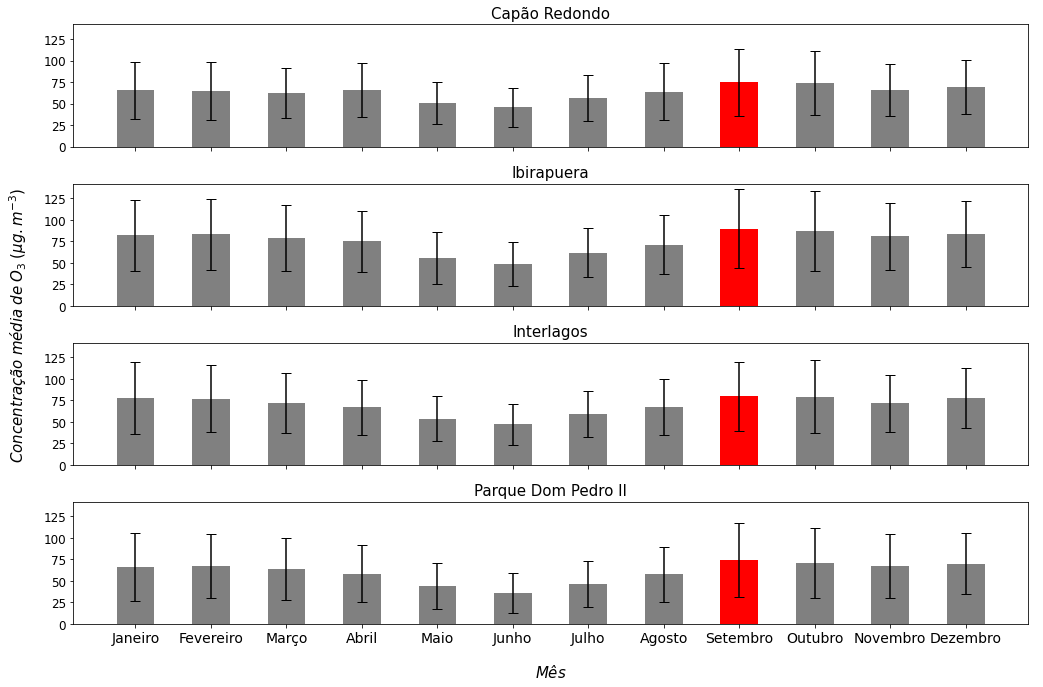

In [188]:
#@title
x_cp_year = cp_by_month_year['mes']
x_ib_year = ib_by_month_year['mes']
x_inter_year = inter_by_month_year['mes']
x_pd_year = pd_by_month_year['mes']

y_cp_year_o3 = cp_by_month_year['O3']
y_ib_year_o3 = ib_by_month_year['O3']
y_inter_year_o3 = inter_by_month_year['O3']
y_pd_year_o3 = pd_by_month_year['O3']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_o3)) 
              else 'grey' for bar in y_cp_year_o3]

color_2 = ['r' if (bar == max(y_ib_year_o3)) 
              else 'grey' for bar in y_ib_year_o3]    

color_3 = ['r' if (bar == max(y_inter_year_o3)) 
              else 'grey' for bar in y_inter_year_o3]  

color_4 = ['r' if (bar == max(y_pd_year_o3)) 
              else 'grey' for bar in y_pd_year_o3]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_o3,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_month_year['O3'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_o3, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_month_year['O3'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_o3, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_month_year['O3'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_o3, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_month_year['O3'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Mês$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'o3_media_mes.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

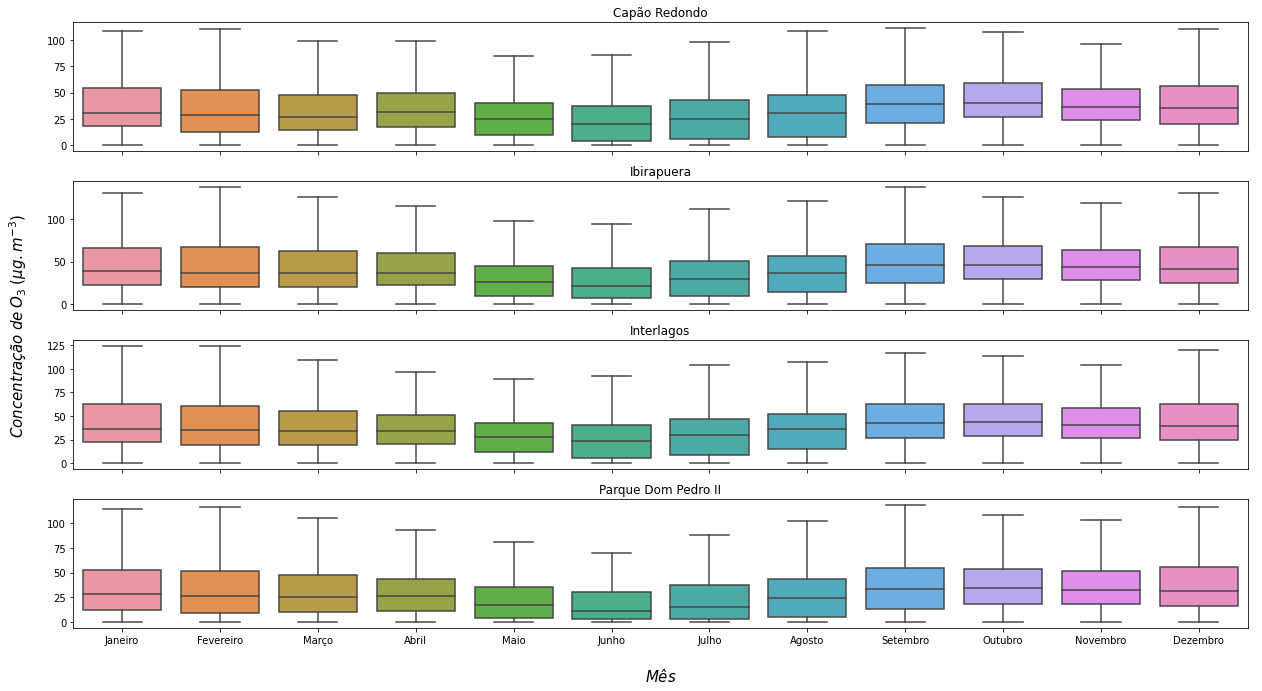

In [189]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(18, 10))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='mes', y='O3', 
            showfliers = False, 
            order = month
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='mes', y='O3', 
            showfliers = False, 
            order = month
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None)  

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='mes', y='O3', 
            showfliers = False, 
            order = month
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='mes', y='O3', 
            showfliers = False, 
            order = month
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Mês$",fontsize=15)
plt.ylabel("$Concentração\;de\;O_{3}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'o3_boxplot_meses_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO

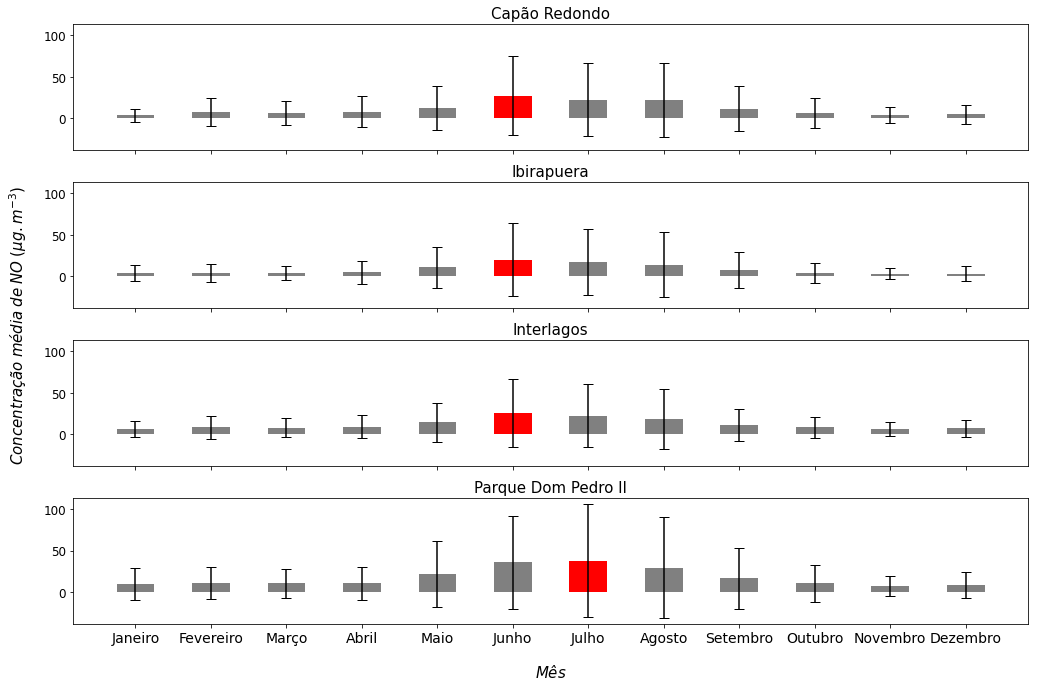

In [190]:
#@title
x_cp_year = cp_by_month_year['mes']
x_ib_year = ib_by_month_year['mes']
x_inter_year = inter_by_month_year['mes']
x_pd_year = pd_by_month_year['mes']

y_cp_year_no = cp_by_month_year['NO']
y_ib_year_no = ib_by_month_year['NO']
y_inter_year_no = inter_by_month_year['NO']
y_pd_year_no = pd_by_month_year['NO']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no)) 
              else 'grey' for bar in y_cp_year_no]

color_2 = ['r' if (bar == max(y_ib_year_no)) 
              else 'grey' for bar in y_ib_year_no]    

color_3 = ['r' if (bar == max(y_inter_year_no)) 
              else 'grey' for bar in y_inter_year_no]  

color_4 = ['r' if (bar == max(y_pd_year_no)) 
              else 'grey' for bar in y_pd_year_no]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_month_year['NO'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_month_year['NO'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_month_year['NO'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_month_year['NO'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Mês$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no_media_mes.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

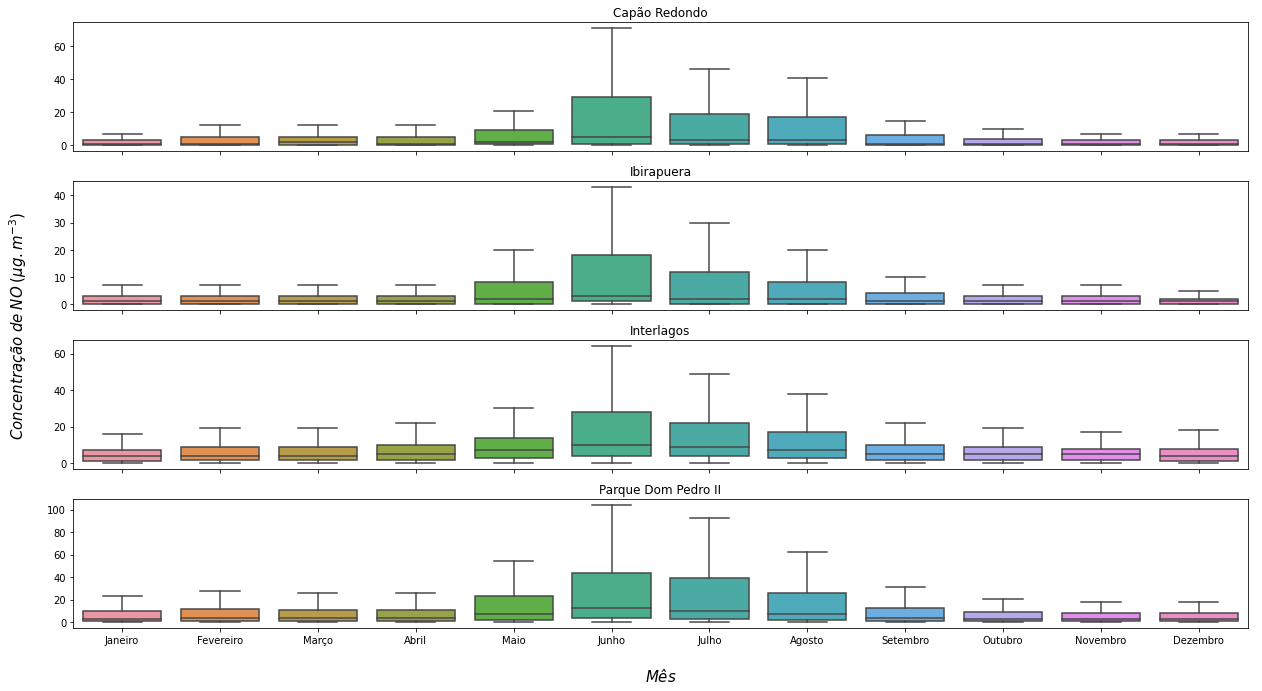

In [191]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(18, 10))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='mes', y='NO', 
            showfliers = False, 
            order = month
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='mes', y='NO', 
            showfliers = False, 
            order = month
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None) 
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='mes', y='NO', 
            showfliers = False, 
            order = month
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='mes', y='NO', 
            showfliers = False,
            order = month
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Mês$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no_boxplot_meses_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO2

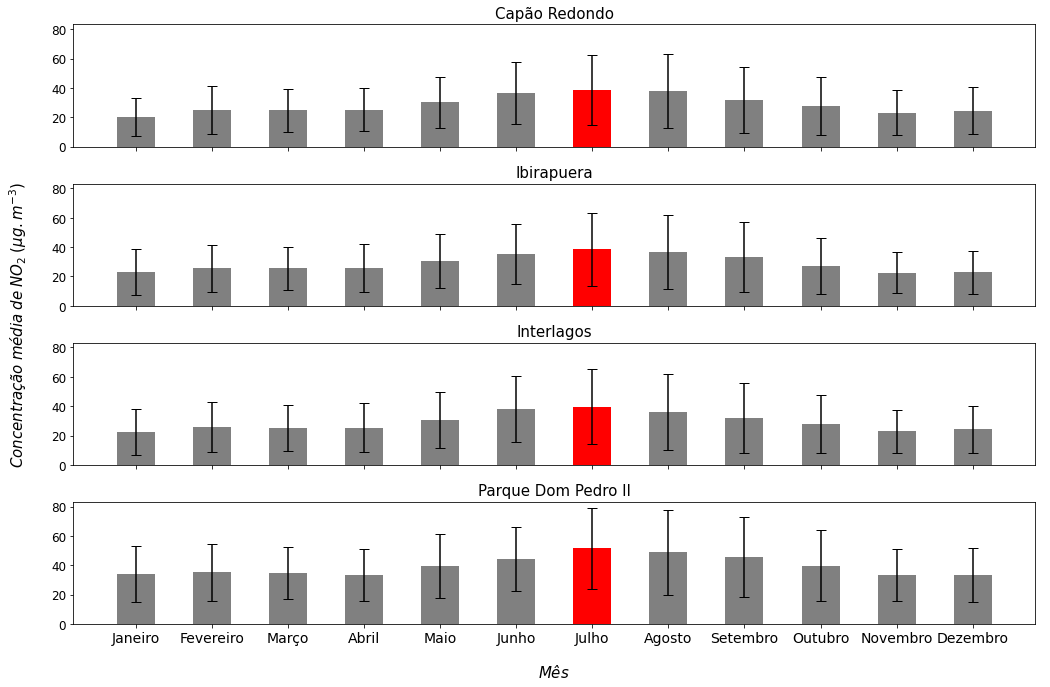

In [192]:
#@title
x_cp_year = cp_by_month_year['mes']
x_ib_year = ib_by_month_year['mes']
x_inter_year = inter_by_month_year['mes']
x_pd_year = pd_by_month_year['mes']

y_cp_year_no2 = cp_by_month_year['NO2']
y_ib_year_no2 = ib_by_month_year['NO2']
y_inter_year_no2 = inter_by_month_year['NO2']
y_pd_year_no2 = pd_by_month_year['NO2']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no2)) 
              else 'grey' for bar in y_cp_year_no2]

color_2 = ['r' if (bar == max(y_ib_year_no2)) 
              else 'grey' for bar in y_ib_year_no2]    

color_3 = ['r' if (bar == max(y_inter_year_no2)) 
              else 'grey' for bar in y_inter_year_no2]  

color_4 = ['r' if (bar == max(y_pd_year_no2)) 
              else 'grey' for bar in y_pd_year_no2]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no2,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_month_year['NO2'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no2, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_month_year['NO2'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no2, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_month_year['NO2'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no2, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_month_year['NO2'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Mês$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no2_media_mes.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

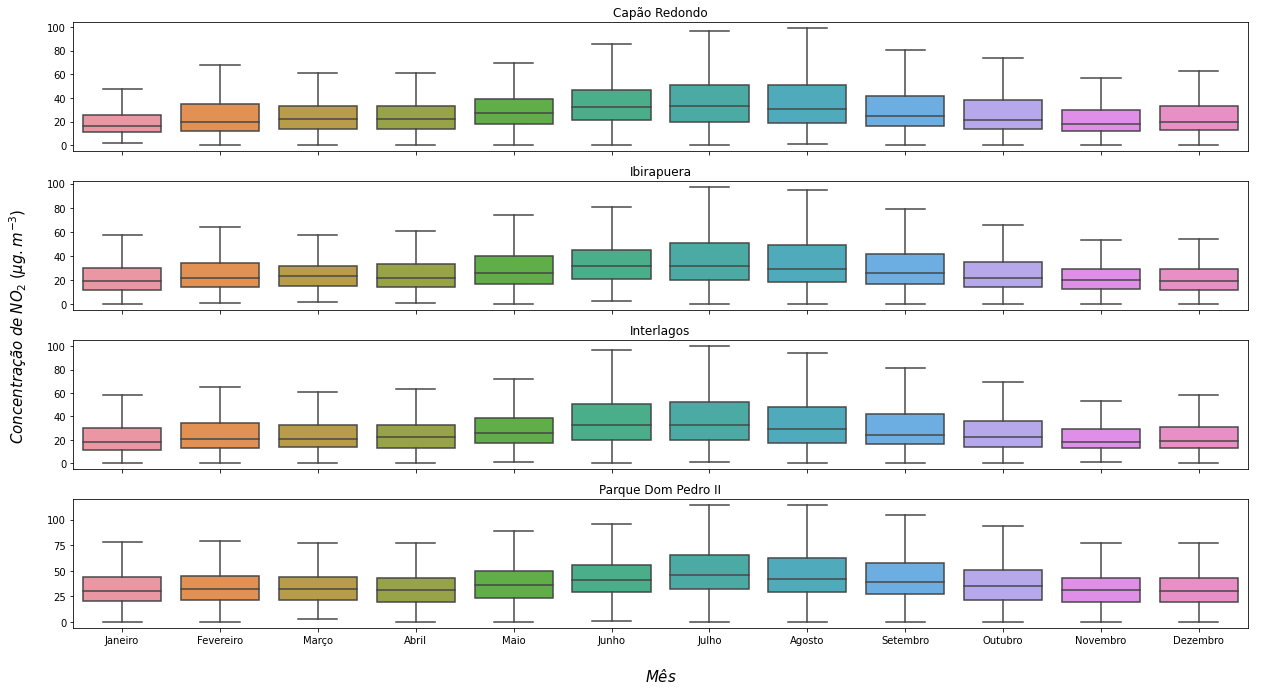

In [193]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(18, 10))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='mes', y='NO2', 
            showfliers = False, 
            order = month
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='mes', y='NO2', 
            showfliers = False, 
            order = month
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None) 

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='mes', y='NO2', 
            showfliers = False, 
            order = month
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='mes', y='NO2', 
            showfliers = False, 
            order = month
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Mês$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO_{2}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no2_boxplot_meses_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Mean concentration for each quarter of the year

In [194]:
#@title
quarter_ptbr = ['Jan-Fev-Mar', 
                'Abr-Mai-Jun', 
                'Jul-Ago-Set', 
                'Out-Nov-Dez']

#####################
#####################

filt_1 = df['estacao'] == 'Capão Redondo'
cp_by_quarter_year_1 = df.loc[filt_1]
cp_by_quarter_year_1 = cp_by_quarter_year_1.groupby(['trimestre'])['NO', 'NO2'].mean()
cp_by_quarter_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_by_quarter_year_2 = df.loc[filt_2]
cp_by_quarter_year_2 = cp_by_quarter_year_2.groupby(['trimestre'])['O3'].mean()
cp_by_quarter_year_2 = pd.DataFrame(data=cp_by_quarter_year_2)

cp_by_quarter_year = cp_by_quarter_year_1.merge(cp_by_quarter_year_2, left_on='trimestre', right_on='trimestre')

cp_by_quarter_year['trimestre_nom'] = quarter_ptbr

# print(cp_by_quarter_year.to_string())

######################
######################

filt_1 = df['estacao'] == 'Ibirapuera'
ib_by_quarter_year_1 = df.loc[filt_1]
ib_by_quarter_year_1 = ib_by_quarter_year_1.groupby(['trimestre'])['NO', 'NO2'].mean()
ib_by_quarter_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_by_quarter_year_2 = df.loc[filt_2]
ib_by_quarter_year_2 = ib_by_quarter_year_2.groupby(['trimestre'])['O3'].mean()
ib_by_quarter_year_2 = pd.DataFrame(data=ib_by_quarter_year_2)

ib_by_quarter_year = ib_by_quarter_year_1.merge(ib_by_quarter_year_2, left_on='trimestre', right_on='trimestre')

ib_by_quarter_year['trimestre_nom'] = quarter_ptbr

# print(ib_by_quarter_year.to_string())

######################
######################

filt_1 = df['estacao'] == 'Interlagos'
inter_by_quarter_year_1 = df.loc[filt_1]
inter_by_quarter_year_1 = inter_by_quarter_year_1.groupby(['trimestre'])['NO', 'NO2'].mean()
inter_by_quarter_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_by_quarter_year_2 = df.loc[filt_2]
inter_by_quarter_year_2 = inter_by_quarter_year_2.groupby(['trimestre'])['O3'].mean()
inter_by_quarter_year_2 = pd.DataFrame(data=inter_by_quarter_year_2)

inter_by_quarter_year = inter_by_quarter_year_1.merge(inter_by_quarter_year_2, left_on='trimestre', right_on='trimestre')

inter_by_quarter_year['trimestre_nom'] = quarter_ptbr

# print(inter_by_quarter_year.to_string())

######################
######################

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
pd_by_quarter_year_1 = df.loc[filt_1]
pd_by_quarter_year_1 = pd_by_quarter_year_1.groupby(['trimestre'])['NO', 'NO2'].mean()
pd_by_quarter_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pd_by_quarter_year_2 = df.loc[filt_2]
pd_by_quarter_year_2 = pd_by_quarter_year_2.groupby(['trimestre'])['O3'].mean()
pd_by_quarter_year_2 = pd.DataFrame(data=pd_by_quarter_year_2)

pd_by_quarter_year = pd_by_quarter_year_1.merge(pd_by_quarter_year_2, left_on='trimestre', right_on='trimestre')

pd_by_quarter_year['trimestre_nom'] = quarter_ptbr

# print(pd_by_quarter_year.to_string())

####O3

In [195]:
#@title
# x_cp_year = cp_by_quarter_year['trimestre_nom']
# x_ib_year = ib_by_quarter_year['trimestre_nom']
# x_inter_year = inter_by_quarter_year['trimestre_nom']
# x_pd_year = pd_by_quarter_year['trimestre_nom']

# y_cp_year_o3 = cp_by_quarter_year['O3']
# y_ib_year_o3 = ib_by_quarter_year['O3']
# y_inter_year_o3 = inter_by_quarter_year['O3']
# y_pd_year_o3 = pd_by_quarter_year['O3']

# width = 0.5

# color_1 = ['r' if (bar == max(y_cp_year_o3)) 
#               else 'grey' for bar in y_cp_year_o3]

# color_2 = ['r' if (bar == max(y_ib_year_o3)) 
#               else 'grey' for bar in y_ib_year_o3]    

# color_3 = ['r' if (bar == max(y_inter_year_o3)) 
#               else 'grey' for bar in y_inter_year_o3]  

# color_4 = ['r' if (bar == max(y_pd_year_o3)) 
#               else 'grey' for bar in y_pd_year_o3]  

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
#                                          ncols=1, 
#                                          sharex=True,
#                                          sharey=True, 
#                                          figsize=(8,10)
#                                         )

# ax1.bar(x_cp_year,y_cp_year_o3,label='Capão Redondo',
#         color=color_1,width = width)
# ax2.bar(x_ib_year, y_ib_year_o3, label='Ibirapuera', 
#         color=color_2,width = width)
# ax3.bar(x_inter_year, y_inter_year_o3, label='Interlagos', 
#         color=color_3,width = width)
# ax4.bar(x_pd_year, y_pd_year_o3, label='Parque Dom Pedro II', 
#         color=color_4,width = width)

# # ax1.legend()
# ax1.set_title('Capão Redondo',fontsize=15)
# # ax1.set_xlabel('')
# # ax1.set_ylabel('')
# # ax1.grid(True)

# # ax2.legend()
# ax2.set_title('Ibirapuera',fontsize=15)
# # ax2.set_xlabel('')
# # ax2.set_ylabel('')
# # ax2.grid(True)

# # ax3.legend()
# ax3.set_title('Interlagos',fontsize=15)
# # ax3.set_xlabel('')
# # ax3.set_ylabel('')
# # ax3.grid(True)

# # ax4.legend()
# ax4.set_title('Parque Dom Pedro II',fontsize=15)
# # ax4.set_xlabel('')
# # ax4.set_ylabel('')
# # ax4.grid(True)

# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', 
#                 which='both', 
#                 top=False, 
#                 bottom=False, 
#                 left=False, 
#                 right=False)

# plt.xlabel("\n$Trimestre$",fontsize=15)
# plt.ylabel("$Concentração\;média\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

# plt.setp(ax4.get_xticklabels(), 
#          fontsize=14
#         )

# plt.setp([ax1.get_yticklabels(),
#           ax2.get_yticklabels(),
#           ax3.get_yticklabels(),
#           ax4.get_yticklabels()], 
#          fontsize=12
#          )

# plt.tight_layout()

# plt.savefig(
#               dir + 'o3_media_trimestre.png',
#               transparent = True,
#               bbox_inches = 'tight',
#               dpi = 500              
#             )

# plt.show()

####NO

In [196]:
#@title
# #@title
# x_cp_year = cp_by_quarter_year['trimestre_nom']
# x_ib_year = ib_by_quarter_year['trimestre_nom']
# x_inter_year = inter_by_quarter_year['trimestre_nom']
# x_pd_year = pd_by_quarter_year['trimestre_nom']

# y_cp_year_no = cp_by_quarter_year['NO']
# y_ib_year_no = ib_by_quarter_year['NO']
# y_inter_year_no = inter_by_quarter_year['NO']
# y_pd_year_no = pd_by_quarter_year['NO']

# width = 0.5

# color_1 = ['r' if (bar == max(y_cp_year_no)) 
#               else 'grey' for bar in y_cp_year_no]

# color_2 = ['r' if (bar == max(y_ib_year_no)) 
#               else 'grey' for bar in y_ib_year_no]    

# color_3 = ['r' if (bar == max(y_inter_year_no)) 
#               else 'grey' for bar in y_inter_year_no]  

# color_4 = ['r' if (bar == max(y_pd_year_no)) 
#               else 'grey' for bar in y_pd_year_no]  

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
#                                          ncols=1, 
#                                          sharex=True,
#                                          sharey=True, 
#                                          figsize=(8,10)
#                                         )

# ax1.bar(x_cp_year,y_cp_year_no,label='Capão Redondo',
#         color=color_1,width = width)
# ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', 
#         color=color_2,width = width)
# ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', 
#         color=color_3,width = width)
# ax4.bar(x_pd_year, y_pd_year_no, label='Parque Dom Pedro II', 
#         color=color_4,width = width)

# # ax1.legend()
# ax1.set_title('Capão Redondo',fontsize=15)
# # ax1.set_xlabel('')
# # ax1.set_ylabel('')
# # ax1.grid(True)

# # ax2.legend()
# ax2.set_title('Ibirapuera',fontsize=15)
# # ax2.set_xlabel('')
# # ax2.set_ylabel('')
# # ax2.grid(True)

# # ax3.legend()
# ax3.set_title('Interlagos',fontsize=15)
# # ax3.set_xlabel('')
# # ax3.set_ylabel('')
# # ax3.grid(True)

# # ax4.legend()
# ax4.set_title('Parque Dom Pedro II',fontsize=15)
# # ax4.set_xlabel('')
# # ax4.set_ylabel('')
# # ax4.grid(True)

# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', 
#                 which='both', 
#                 top=False, 
#                 bottom=False, 
#                 left=False, 
#                 right=False)

# plt.xlabel("\n$Trimestre$",fontsize=15)
# plt.ylabel("$Concentração\;média\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

# plt.setp(ax4.get_xticklabels(), 
#          fontsize=14
#         )

# plt.setp([ax1.get_yticklabels(),
#           ax2.get_yticklabels(),
#           ax3.get_yticklabels(),
#           ax4.get_yticklabels()], 
#          fontsize=12
#          )


# plt.tight_layout()

# plt.savefig(
#               dir + 'no_media_trimestre.png',
#               transparent = True,
#               bbox_inches = 'tight',
#               dpi = 500              
#             )

# plt.show()

####NO2

In [197]:
#@title
# #@title
# x_cp_year = cp_by_quarter_year['trimestre_nom']
# x_ib_year = ib_by_quarter_year['trimestre_nom']
# x_inter_year = inter_by_quarter_year['trimestre_nom']
# x_pd_year = pd_by_quarter_year['trimestre_nom']

# y_cp_year_no2 = cp_by_quarter_year['NO2']
# y_ib_year_no2 = ib_by_quarter_year['NO2']
# y_inter_year_no2 = inter_by_quarter_year['NO2']
# y_pd_year_no2 = pd_by_quarter_year['NO2']

# width = 0.5

# color_1 = ['r' if (bar == max(y_cp_year_no2)) 
#               else 'grey' for bar in y_cp_year_no2]

# color_2 = ['r' if (bar == max(y_ib_year_no2)) 
#               else 'grey' for bar in y_ib_year_no2]    

# color_3 = ['r' if (bar == max(y_inter_year_no2)) 
#               else 'grey' for bar in y_inter_year_no2]  

# color_4 = ['r' if (bar == max(y_pd_year_no2)) 
#               else 'grey' for bar in y_pd_year_no2]  

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
#                                          ncols=1, 
#                                          sharex=True,
#                                          sharey=True, 
#                                          figsize=(8,10)
#                                         )

# ax1.bar(x_cp_year,y_cp_year_no2,label='Capão Redondo',
#         color=color_1,width = width)
# ax2.bar(x_ib_year, y_ib_year_no2, label='Ibirapuera', 
#         color=color_2,width = width)
# ax3.bar(x_inter_year, y_inter_year_no2, label='Interlagos', 
#         color=color_3,width = width)
# ax4.bar(x_pd_year, y_pd_year_no2, label='Parque Dom Pedro II', 
#         color=color_4,width = width)

# # ax1.legend()
# ax1.set_title('Capão Redondo',fontsize=15)
# # ax1.set_xlabel('')
# # ax1.set_ylabel('')
# # ax1.grid(True)

# # ax2.legend()
# ax2.set_title('Ibirapuera',fontsize=15)
# # ax2.set_xlabel('')
# # ax2.set_ylabel('')
# # ax2.grid(True)

# # ax3.legend()
# ax3.set_title('Interlagos',fontsize=15)
# # ax3.set_xlabel('')
# # ax3.set_ylabel('')
# # ax3.grid(True)

# # ax4.legend()
# ax4.set_title('Parque Dom Pedro II',fontsize=15)
# # ax4.set_xlabel('')
# # ax4.set_ylabel('')
# # ax4.grid(True)

# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', 
#                 which='both', 
#                 top=False, 
#                 bottom=False, 
#                 left=False, 
#                 right=False)

# plt.xlabel("\n$Trimestre$",fontsize=15)
# plt.ylabel("$Concentração\;média\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

# plt.setp(ax4.get_xticklabels(), 
#          fontsize=14
#         )

# plt.setp([ax1.get_yticklabels(),
#           ax2.get_yticklabels(),
#           ax3.get_yticklabels(),
#           ax4.get_yticklabels()], 
#          fontsize=12
#          )


# plt.tight_layout()

# plt.savefig(
#               dir + 'no2_media_trimestre.png',
#               transparent = True,
#               bbox_inches = 'tight',
#               dpi = 500              
#             )

# plt.show()

###Mean concentration for each season of the year

http://www.estacao.iag.usp.br/seasons/index.php

In [198]:
#@title
estacoes_ano_ptbr = { 'Janeiro':'Verão', 
                      'Fevereiro':'Verão', 
                      'Março':'Outono', 
                      'Abril':'Outono', 
                      'Maio':'Outono', 
                      'Junho':'Inverno', 
                      'Julho':'Inverno',
                      'Agosto':'Inverno', 
                      'Setembro':'Primavera',
                      'Outubro':'Primavera', 
                      'Novembro':'Primavera',
                      'Dezembro':'Verão' }

df['estacoes_do_ano'] = df['mes'].replace(estacoes_ano_ptbr)

#####################
#       MEAN
#####################

filt_1 = df['estacao'] == 'Capão Redondo'
cp_by_season_year_1 = df.loc[filt_1]
cp_by_season_year_1 = cp_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].mean()
cp_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
cp_by_season_year_2 = df.loc[filt_2]
cp_by_season_year_2 = cp_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].mean()
cp_by_season_year_2 = pd.DataFrame(data=cp_by_season_year_2)

cp_by_season_year = cp_by_season_year_1.merge(cp_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(cp_by_season_year.to_string())

filt_1 = df['estacao'] == 'Ibirapuera'
ib_by_season_year_1 = df.loc[filt_1]
ib_by_season_year_1 = ib_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].mean()
ib_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
ib_by_season_year_2 = df.loc[filt_2]
ib_by_season_year_2 = ib_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].mean()
ib_by_season_year_2 = pd.DataFrame(data=ib_by_season_year_2)

ib_by_season_year = ib_by_season_year_1.merge(ib_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(ib_by_season_year.to_string())

filt_1 = df['estacao'] == 'Interlagos'
inter_by_season_year_1 = df.loc[filt_1]
inter_by_season_year_1 = inter_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].mean()
inter_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
inter_by_season_year_2 = df.loc[filt_2]
inter_by_season_year_2 = inter_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].mean()
inter_by_season_year_2 = pd.DataFrame(data=inter_by_season_year_2)

inter_by_season_year = inter_by_season_year_1.merge(inter_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(inter_by_season_year.to_string())

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
pd_by_season_year_1 = df.loc[filt_1]
pd_by_season_year_1 = pd_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].mean()
pd_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
pd_by_season_year_2 = df.loc[filt_2]
pd_by_season_year_2 = pd_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].mean()
pd_by_season_year_2 = pd.DataFrame(data=pd_by_season_year_2)

pd_by_season_year = pd_by_season_year_1.merge(pd_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(pd_by_season_year.to_string())

##########################
#   Standard Deviation
##########################

filt_1 = df['estacao'] == 'Capão Redondo'
std_cp_by_season_year_1 = df.loc[filt_1]
std_cp_by_season_year_1 = std_cp_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].std()
std_cp_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Capão Redondo') & (df.horas.isin(horas))
std_cp_by_season_year_2 = df.loc[filt_2]
std_cp_by_season_year_2 = std_cp_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].std()
std_cp_by_season_year_2 = pd.DataFrame(data=std_cp_by_season_year_2)

std_cp_by_season_year = std_cp_by_season_year_1.merge(std_cp_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(std_cp_by_season_year.to_string())

filt_1 = df['estacao'] == 'Ibirapuera'
std_ib_by_season_year_1 = df.loc[filt_1]
std_ib_by_season_year_1 = std_ib_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].std()
std_ib_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Ibirapuera') & (df.horas.isin(horas))
std_ib_by_season_year_2 = df.loc[filt_2]
std_ib_by_season_year_2 = std_ib_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].std()
std_ib_by_season_year_2 = pd.DataFrame(data=std_ib_by_season_year_2)

std_ib_by_season_year = std_ib_by_season_year_1.merge(std_ib_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(std_ib_by_season_year.to_string())

filt_1 = df['estacao'] == 'Interlagos'
std_inter_by_season_year_1 = df.loc[filt_1]
std_inter_by_season_year_1 = std_inter_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].std()
std_inter_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Interlagos') & (df.horas.isin(horas))
std_inter_by_season_year_2 = df.loc[filt_2]
std_inter_by_season_year_2 = std_inter_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].std()
std_inter_by_season_year_2 = pd.DataFrame(data=std_inter_by_season_year_2)

std_inter_by_season_year = std_inter_by_season_year_1.merge(std_inter_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(std_inter_by_season_year.to_string())

filt_1 = df['estacao'] == 'Parque Dom Pedro II'
std_pd_by_season_year_1 = df.loc[filt_1]
std_pd_by_season_year_1 = std_pd_by_season_year_1.groupby(['estacoes_do_ano'])['NO', 'NO2'].std()
std_pd_by_season_year_1.reset_index(inplace=True)

###########

filt_2 = (df.estacao == 'Parque Dom Pedro II') & (df.horas.isin(horas))
std_pd_by_season_year_2 = df.loc[filt_2]
std_pd_by_season_year_2 = std_pd_by_season_year_2.groupby(['estacoes_do_ano'])['O3'].std()
std_pd_by_season_year_2 = pd.DataFrame(data=std_pd_by_season_year_2)

std_pd_by_season_year = std_pd_by_season_year_1.merge(std_pd_by_season_year_2, left_on='estacoes_do_ano', right_on='estacoes_do_ano')

# print(std_pd_by_season_year.to_string())

####O3

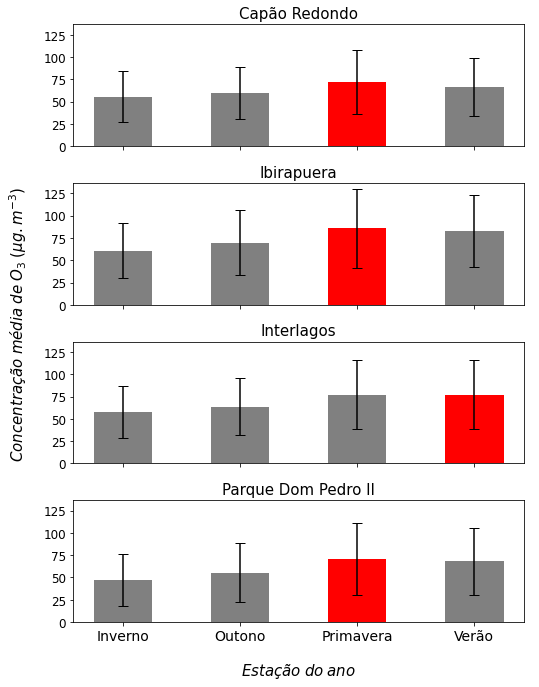

In [199]:
#@title
x_cp_year = cp_by_season_year['estacoes_do_ano']
x_ib_year = ib_by_season_year['estacoes_do_ano']
x_inter_year = inter_by_season_year['estacoes_do_ano']
x_pd_year = pd_by_season_year['estacoes_do_ano']

y_cp_year_o3 = cp_by_season_year['O3']
y_ib_year_o3 = ib_by_season_year['O3']
y_inter_year_o3 = inter_by_season_year['O3']
y_pd_year_o3 = pd_by_season_year['O3']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_o3)) 
              else 'grey' for bar in y_cp_year_o3]

color_2 = ['r' if (bar == max(y_ib_year_o3)) 
              else 'grey' for bar in y_ib_year_o3]    

color_3 = ['r' if (bar == max(y_inter_year_o3)) 
              else 'grey' for bar in y_inter_year_o3]  

color_4 = ['r' if (bar == max(y_pd_year_o3)) 
              else 'grey' for bar in y_pd_year_o3]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(8,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_o3,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_season_year['O3'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_o3, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_season_year['O3'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_o3, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_season_year['O3'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_o3, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_season_year['O3'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Estação\;do\;ano$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'o3_media_estacao_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

In [200]:
df['estacoes_do_ano'] = df['mes'].replace(estacoes_ano_ptbr)

season = ['Inverno', 'Outono', 'Primavera', 'Verão']

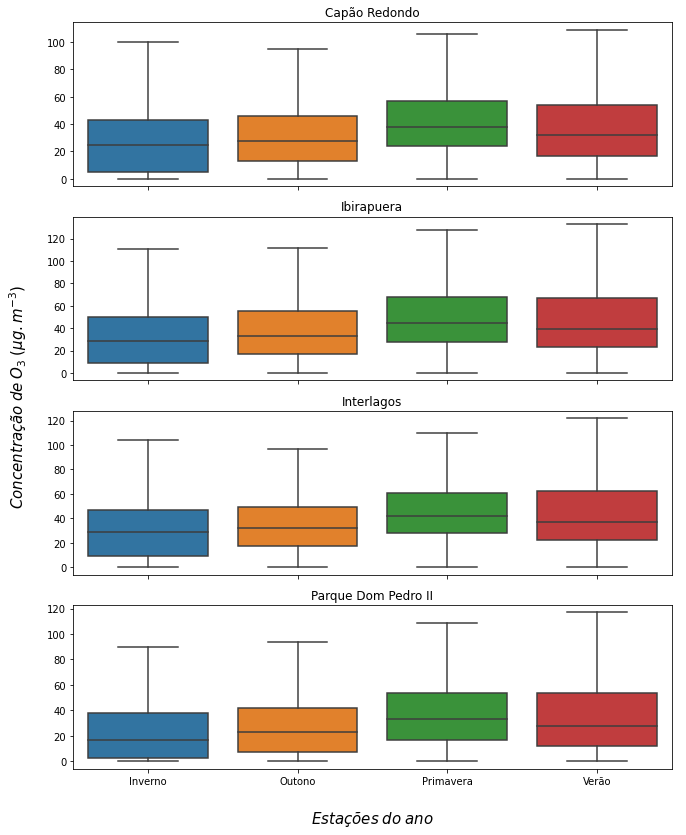

In [201]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='estacoes_do_ano', y='O3', 
            showfliers = False, 
            order = season
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='estacoes_do_ano', y='O3', 
            showfliers = False, 
            order = season
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)  
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='estacoes_do_ano', y='O3', 
            showfliers = False, 
            order = season
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='estacoes_do_ano', y='O3', 
            showfliers = False, 
            order = season
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Estações\;do\;ano$",fontsize=15)
plt.ylabel("$Concentração\;de\;O_{3}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'o3_boxplot_estacoes_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO

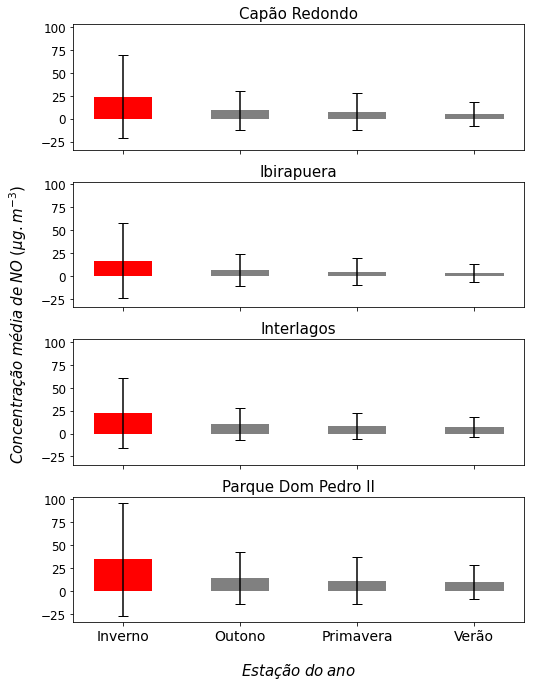

In [202]:
#@title
x_cp_year = cp_by_season_year['estacoes_do_ano']
x_ib_year = ib_by_season_year['estacoes_do_ano']
x_inter_year = inter_by_season_year['estacoes_do_ano']
x_pd_year = pd_by_season_year['estacoes_do_ano']

y_cp_year_no = cp_by_season_year['NO']
y_ib_year_no = ib_by_season_year['NO']
y_inter_year_no = inter_by_season_year['NO']
y_pd_year_no = pd_by_season_year['NO']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no)) 
              else 'grey' for bar in y_cp_year_no]

color_2 = ['r' if (bar == max(y_ib_year_no)) 
              else 'grey' for bar in y_ib_year_no]    

color_3 = ['r' if (bar == max(y_inter_year_no)) 
              else 'grey' for bar in y_inter_year_no]  

color_4 = ['r' if (bar == max(y_pd_year_no)) 
              else 'grey' for bar in y_pd_year_no]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(8,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_season_year['NO'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_season_year['NO'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_season_year['NO'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_season_year['NO'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Estação\;do\;ano$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no_media_estacao_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

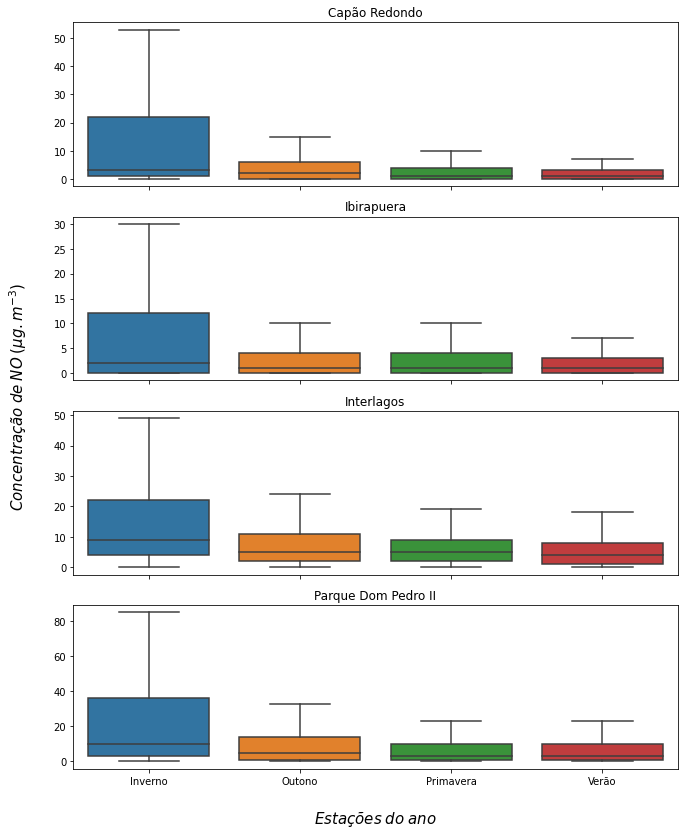

In [203]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='estacoes_do_ano', y='NO', 
            showfliers = False, 
            order = season
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='estacoes_do_ano', y='NO', 
            showfliers = False, 
            order = season
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None) 
g2.set(ylabel=None) 

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='estacoes_do_ano', y='NO', 
            showfliers = False, 
            order = season
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='estacoes_do_ano', y='NO', 
            showfliers = False, 
            order = season
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Estações\;do\;ano$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no_boxplot_estacoes_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####NO2

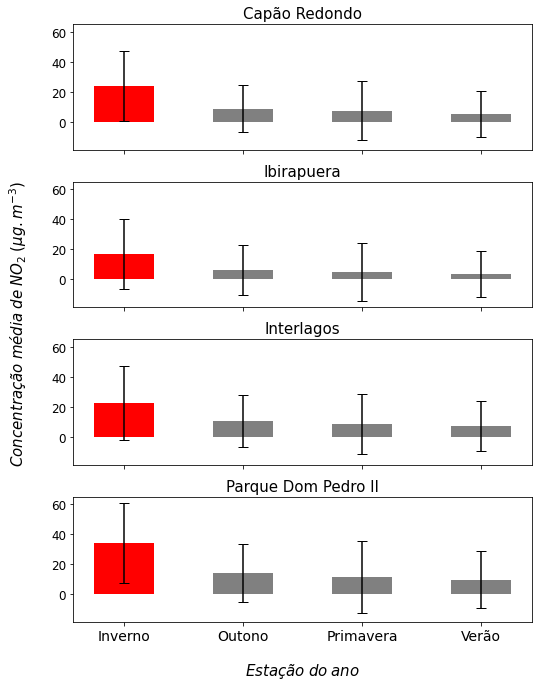

In [204]:
#@title
x_cp_year = cp_by_season_year['estacoes_do_ano']
x_ib_year = ib_by_season_year['estacoes_do_ano']
x_inter_year = inter_by_season_year['estacoes_do_ano']
x_pd_year = pd_by_season_year['estacoes_do_ano']

y_cp_year_no2 = cp_by_season_year['NO2']
y_ib_year_no2 = ib_by_season_year['NO2']
y_inter_year_no2 = inter_by_season_year['NO2']
y_pd_year_no2 = pd_by_season_year['NO2']

width = 0.5

color_1 = ['r' if (bar == max(y_cp_year_no2)) 
              else 'grey' for bar in y_cp_year_no2]

color_2 = ['r' if (bar == max(y_ib_year_no2)) 
              else 'grey' for bar in y_ib_year_no2]    

color_3 = ['r' if (bar == max(y_inter_year_no2)) 
              else 'grey' for bar in y_inter_year_no2]  

color_4 = ['r' if (bar == max(y_pd_year_no2)) 
              else 'grey' for bar in y_pd_year_no2]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(8,10)
                                        )

ax1.bar(x_cp_year,y_cp_year_no,label='Capão Redondo',
        color=color_1,width = width,yerr=std_cp_by_season_year['NO2'],
        ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', 
        color=color_2,width = width,yerr=std_ib_by_season_year['NO2'],
        ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', 
        color=color_3,width = width,yerr=std_inter_by_season_year['NO2'],
        ecolor='black',capsize=5)
ax4.bar(x_pd_year, y_pd_year_no, label='Parque Dom Pedro II', 
        color=color_4,width = width,yerr=std_pd_by_season_year['NO2'],
        ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlabel('')
ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Estação\;do\;ano$",fontsize=15)
plt.ylabel("$Concentração\;média\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no2_media_estacao_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

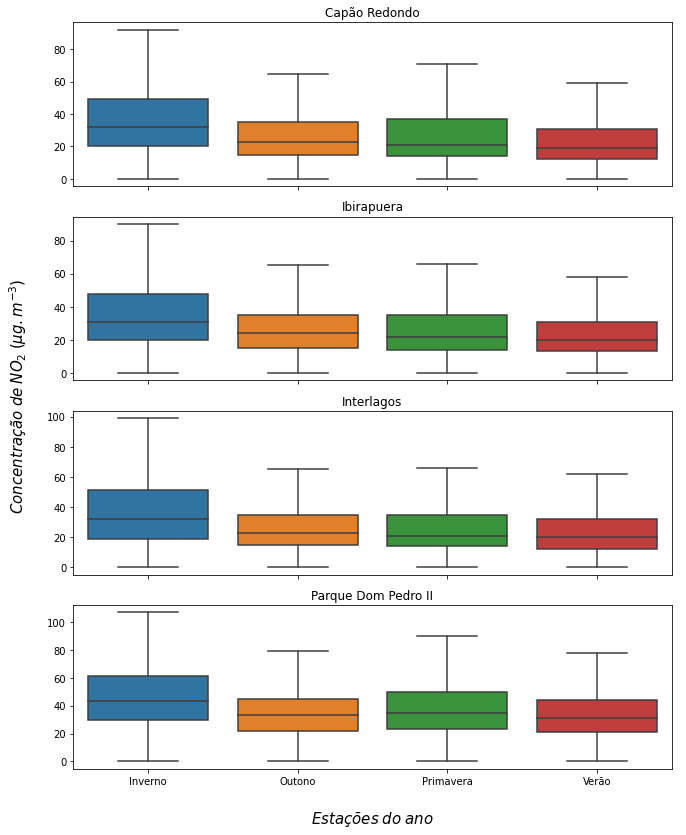

In [205]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='estacoes_do_ano', y='NO2', 
            showfliers = False, 
            order = season
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='estacoes_do_ano', y='NO2', 
            showfliers = False, 
            order = season
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)
g2.set(ylabel=None)  

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='estacoes_do_ano', y='NO2', 
            showfliers = False, 
            order = season
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='estacoes_do_ano', y='NO2', 
            showfliers = False, 
            order = season
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Estações\;do\;ano$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO_{2}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no2_boxplot_estacoes_do_ano.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Hourly Concentratiom

https://cetesb.sp.gov.br/ar/padroes-de-qualidade-do-ar/#:~:text=%C3%8Dndice%20de%20qualidade%20do%20ar%20e%20sa%C3%BAde&text=pela%20CETESB%20s%C3%A3o%3A-,part%C3%ADculas%20inal%C3%A1veis%20(MP10),oz%C3%B4nio%20(O3)

https://cetesb.sp.gov.br/ar/poluentes/

###O3

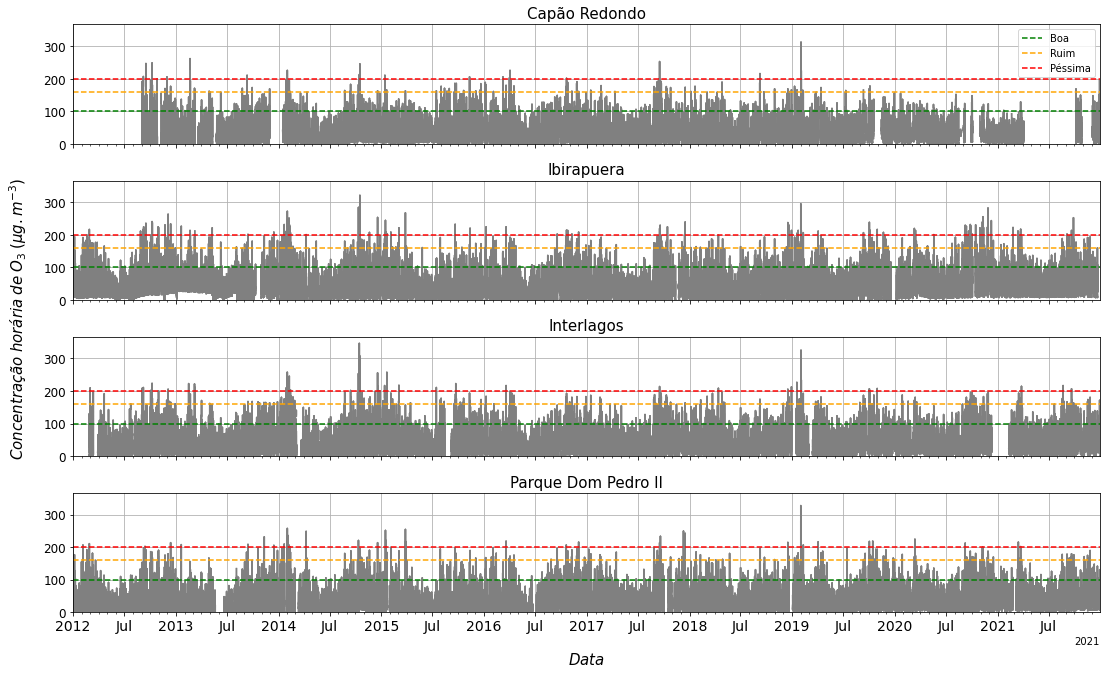

In [206]:
#@title
x_cp_hour = cp_hour['data_hora']
x_ib_hour = ib_hour['data_hora']
x_inter_hour = inter_hour['data_hora']
x_pq_hour = pq_hour['data_hora']

y_cp_hour_o3 = cp_hour['O3']
y_ib_hour_o3 = ib_hour['O3']
y_inter_hour_o3 = inter_hour['O3']
y_pq_hour_o3 = pq_hour['O3']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10),
                                        )

####

ax1.plot(x_cp_hour, 
         y_cp_hour_o3, 
        #  label='Capão Redondo', 
         color='grey'
         )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_hour, y_ib_hour_o3, label='Ibirapuera', color='grey')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_hour, y_inter_hour_o3, label='Interlagos', color='grey')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_hour, y_pq_hour_o3, label='Parque Dom Pedro II', color='grey')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####################
####################

ax1.plot(x_cp_hour, y_cp_hour_o3, color='grey')
ax1.axhline(y = 100, color = 'green', linestyle = '--', label= 'Boa')
ax1.axhline(y = 160, color = 'orange', linestyle = '--', label= 'Ruim')
ax1.axhline(y = 200, color = 'red', linestyle = '--', label= 'Péssima')
ax2.plot(x_ib_hour, y_ib_hour_o3, color='grey')
ax2.axhline(y = 100, color = 'green', linestyle = '--')
ax2.axhline(y = 160, color = 'orange', linestyle = '--')
ax2.axhline(y = 200, color = 'red', linestyle = '--')
ax3.plot(x_inter_hour, y_inter_hour_o3, color='grey')
ax3.axhline(y = 100, color = 'green', linestyle = '--')
ax3.axhline(y = 160, color = 'orange', linestyle = '--')
ax3.axhline(y = 200, color = 'red', linestyle = '--')
ax4.plot(x_pq_hour, y_pq_hour_o3, color='grey')
ax4.axhline(y = 100, color = 'green', linestyle = '--')
ax4.axhline(y = 160, color = 'orange', linestyle = '--')
ax4.axhline(y = 200, color = 'red', linestyle = '--')

####################
####################

ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_hour_o3.max(),
         y_ib_hour_o3.max(),
         y_inter_hour_o3.max(),
         y_pq_hour_o3.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

########

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;horária\;de\;O_{3}\;(µg.m^{-3})$\n", fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'o3_media_horaria.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####Hystogram

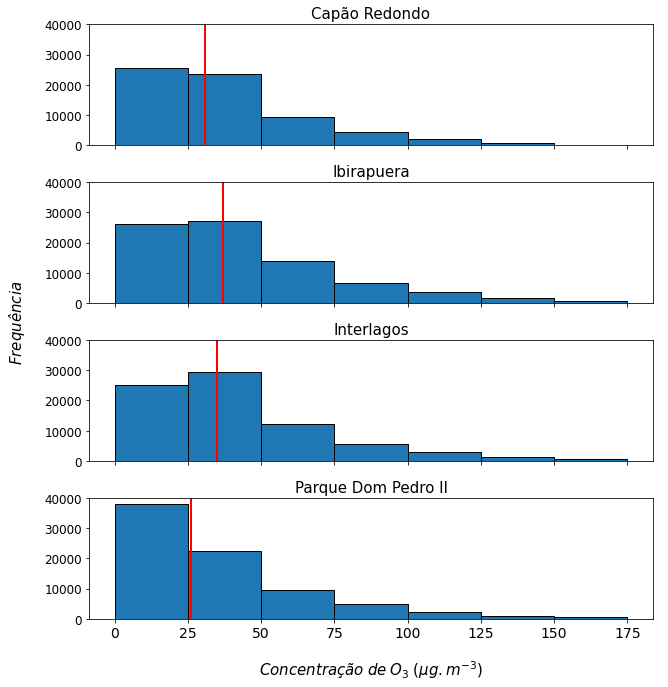

In [207]:
#@title
bins_o3 = list(range(0, 200, 25))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(10,10)
                                        )

ax1.hist(cp_hour['O3'], label='Capão Redondo', bins = bins_o3, edgecolor='black')
ax1.axvline(cp_hour['O3'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax2.hist(ib_hour['O3'], label='Ibirapuera', bins = bins_o3, edgecolor='black')
ax2.axvline(ib_hour['O3'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax3.hist(inter_hour['O3'], label='Interlagos', bins = bins_o3, edgecolor='black')
ax3.axvline(inter_hour['O3'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax4.hist(pq_hour['O3'], label='Parque Dom Pedro II', bins = bins_o3, edgecolor='black')
ax4.axvline(pq_hour['O3'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Concentração\;de\;O_{3}\;(µg.m^{-3})$",fontsize=15)
plt.ylabel("$Frequência$\n\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'o3_histograma.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###NO

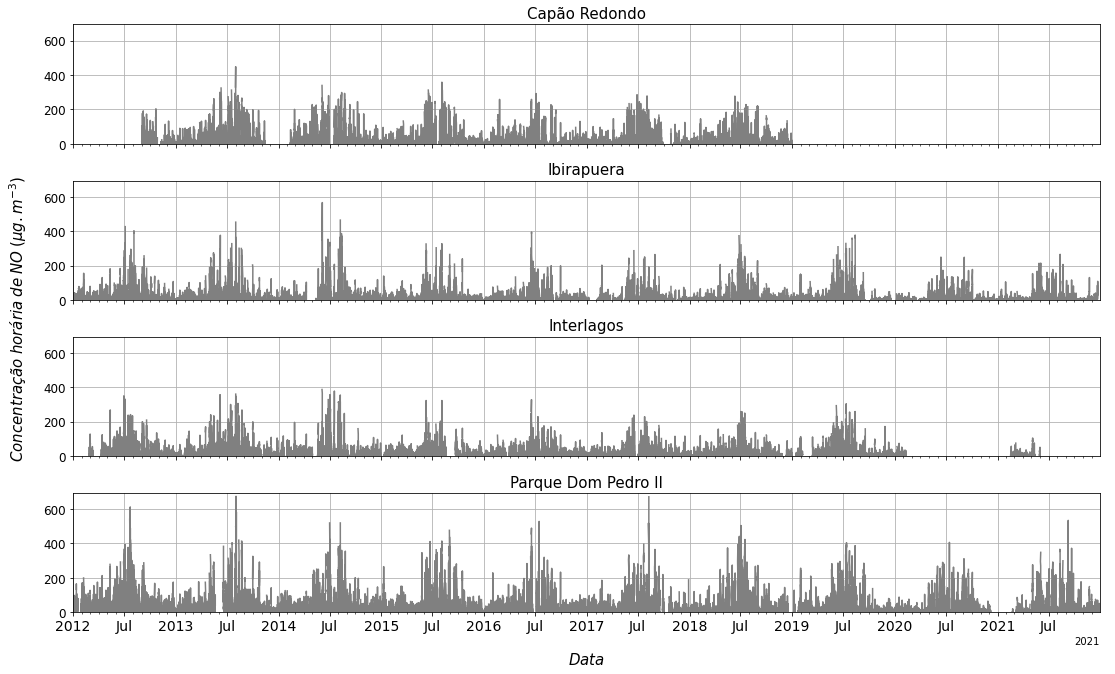

In [208]:
#@title
x_cp_hour = cp_hour['data_hora']
x_ib_hour = ib_hour['data_hora']
x_inter_hour = inter_hour['data_hora']
x_pq_hour = pq_hour['data_hora']

y_cp_hour_no = cp_hour['NO']
y_ib_hour_no = ib_hour['NO']
y_inter_hour_no = inter_hour['NO']
y_pq_hour_no = pq_hour['NO']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_hour, 
         y_cp_hour_no, 
        #  label='Capão Redondo', 
         color='grey'
         )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_hour, y_ib_hour_no, label='Ibirapuera', color='grey')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_hour, y_inter_hour_no, label='Interlagos', color='grey')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_hour, y_pq_hour_no, label='Parque Dom Pedro II', color='grey')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

######

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_hour_no.max(),
         y_ib_hour_no.max(),
         y_inter_hour_no.max(),
         y_pq_hour_no.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

########

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;horária\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no_media_horaria.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####Hystogram

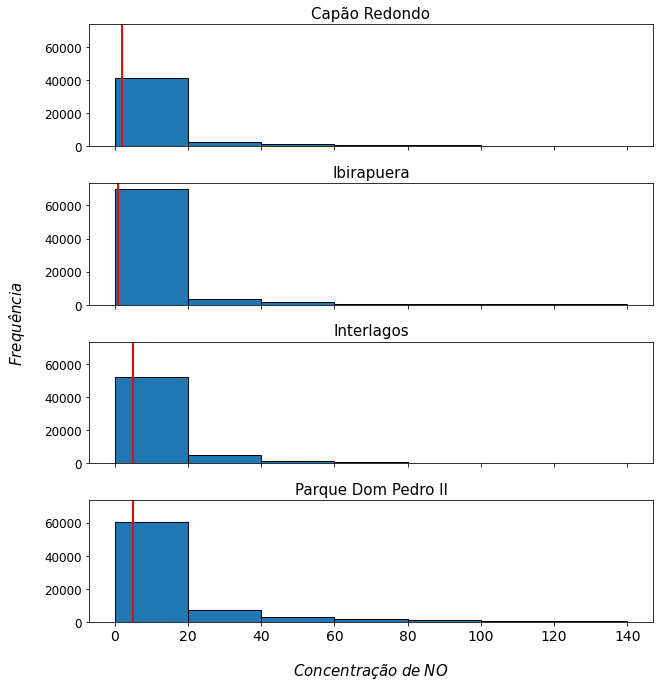

In [209]:
#@title
bins_no = list(range(0, 150, 20))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(10,10)
                                        )

ax1.hist(cp_hour['NO'], label='Capão Redondo', bins = bins_no, edgecolor='black')
ax1.axvline(cp_hour['NO'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax2.hist(ib_hour['NO'], label='Ibirapuera', bins = bins_no, edgecolor='black')
ax2.axvline(ib_hour['NO'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax3.hist(inter_hour['NO'], label='Interlagos', bins = bins_no, edgecolor='black')
ax3.axvline(inter_hour['NO'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax4.hist(pq_hour['NO'], label='Parque Dom Pedro II', bins = bins_no, edgecolor='black')
ax4.axvline(pq_hour['NO'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Concentração\;de\;NO}\;(µg.m^{-3})$",fontsize=15)
plt.ylabel("$Frequência$\n\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no_histograma.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###NO2

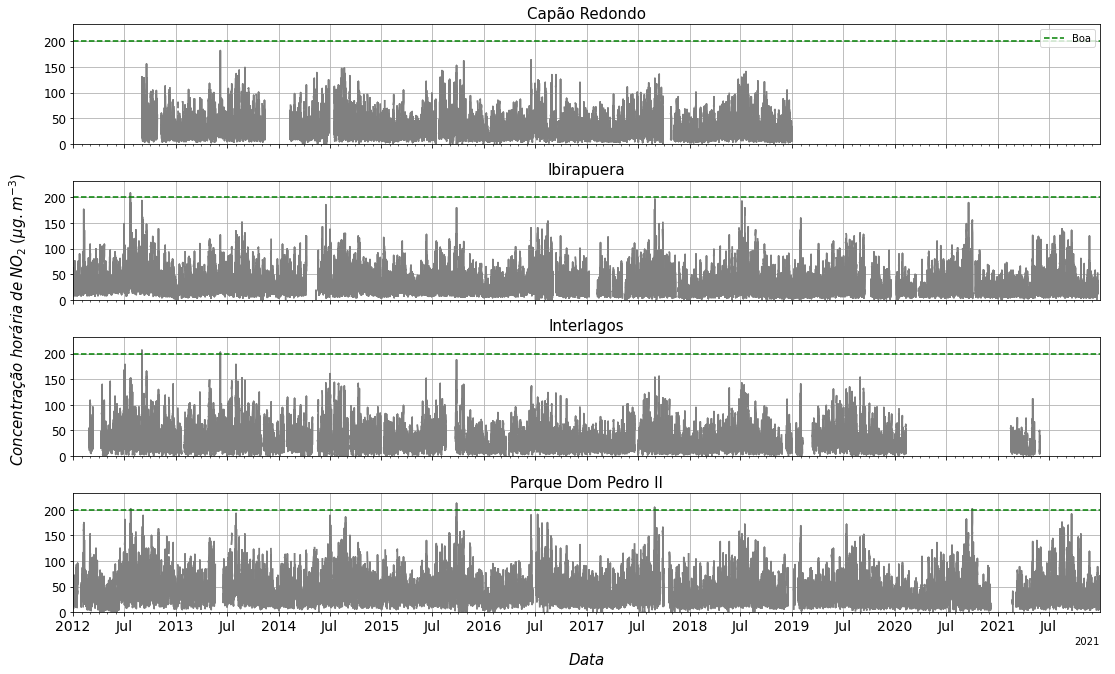

In [210]:
#@title
x_cp_hour = cp_hour['data_hora']
x_ib_hour = ib_hour['data_hora']
x_inter_hour = inter_hour['data_hora']
x_pq_hour = pq_hour['data_hora']

y_cp_hour_no2 = cp_hour['NO2']
y_ib_hour_no2 = ib_hour['NO2']
y_inter_hour_no2 = inter_hour['NO2']
y_pq_hour_no2 = pq_hour['NO2']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_hour, 
         y_cp_hour_no2, 
        #  label='Capão Redondo', 
         color='grey'
         )

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_hour, y_ib_hour_no2, label='Ibirapuera', color='grey')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_hour, y_inter_hour_no2, label='Interlagos', color='grey')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_hour, y_pq_hour_no2, label='Parque Dom Pedro II', color='grey')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

#######

ax1.plot(x_cp_hour, y_cp_hour_no2, color='grey')
ax1.axhline(y = 200, color = 'green', linestyle = '--', label= 'Boa')
# ax1.axhline(y = 320, color = 'orange', linestyle = '--', label= 'Ruim')
ax2.plot(x_ib_hour, y_ib_hour_no2, label='Ibirapuera', color='grey')
ax2.axhline(y = 200, color = 'green', linestyle = '--')
ax2.axhline(y = 320, color = 'orange', linestyle = '--')
ax3.plot(x_inter_hour, y_inter_hour_no2, label='Interlagos', color='grey')
ax3.axhline(y = 200, color = 'green', linestyle = '--')
ax3.axhline(y = 320, color = 'orange', linestyle = '--')
ax4.plot(x_pq_hour, y_pq_hour_no2, label='Parque Dom Pedro II', color='grey')
ax4.axhline(y = 200, color = 'green', linestyle = '--')
ax4.axhline(y = 320, color = 'orange', linestyle = '--')

ax1.legend(loc='upper right')
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_hour_no2.max(),
         y_ib_hour_no2.max(),
         y_inter_hour_no2.max(),
         y_pq_hour_no2.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

########

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;horária\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )

plt.tight_layout()

plt.savefig(
              dir + 'no2_media_horaria.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####Hystogram

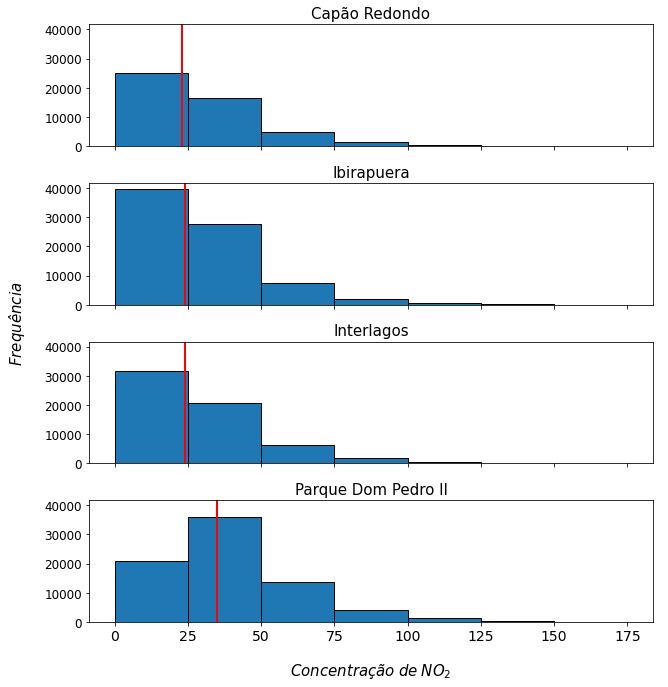

In [211]:
#@title
bins_no2 = list(range(0, 200, 25))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(10,10)
                                        )

ax1.hist(cp_hour['NO2'], label='Capão Redondo', bins = bins_no2, edgecolor='black')
ax1.axvline(cp_hour['NO2'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax2.hist(ib_hour['NO2'], label='Ibirapuera', bins = bins_no2, edgecolor='black')
ax2.axvline(ib_hour['NO2'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax3.hist(inter_hour['NO2'], label='Interlagos', bins = bins_no2, edgecolor='black')
ax3.axvline(inter_hour['NO2'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

ax4.hist(pq_hour['NO2'], label='Parque Dom Pedro II', bins = bins_no2, edgecolor='black')
ax4.axvline(pq_hour['NO2'].median(),
            color='red',
            label='Mediana',
            linewidth=2
          )

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Concentração\;de\;NO_{2}}\;(µg.m^{-3})$",fontsize=15)
plt.ylabel("$Frequência$\n\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no2_histograma.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Daily Mean Concentration

###O3

####All day long

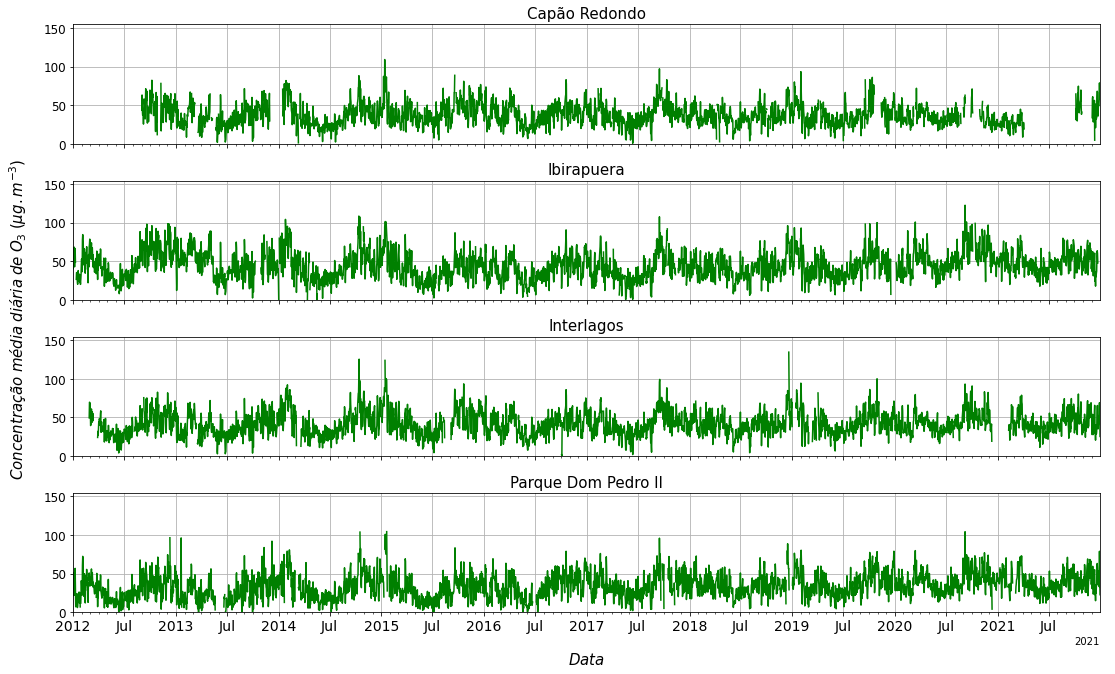

In [212]:
#@title
x_cp_day = cp_day['data_hora']
x_ib_day = ib_day['data_hora']
x_inter_day = inter_day['data_hora']
x_pq_day = pq_day['data_hora']

y_cp_day_o3 = cp_day['O3']
y_ib_day_o3 = ib_day['O3']
y_inter_day_o3 = inter_day['O3']
y_pq_day_o3 = pq_day['O3']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_day, y_cp_day_o3, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_day, y_ib_day_o3, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_day, y_inter_day_o3, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_day, y_pq_day_o3, label='Parque Dom Pedro II', color='green')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_day_o3.max(),
         y_ib_day_o3.max(),
         y_inter_day_o3.max(),
         y_pq_day_o3.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;diária\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'o3_media_diaria.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####8-hour period by day

###NO

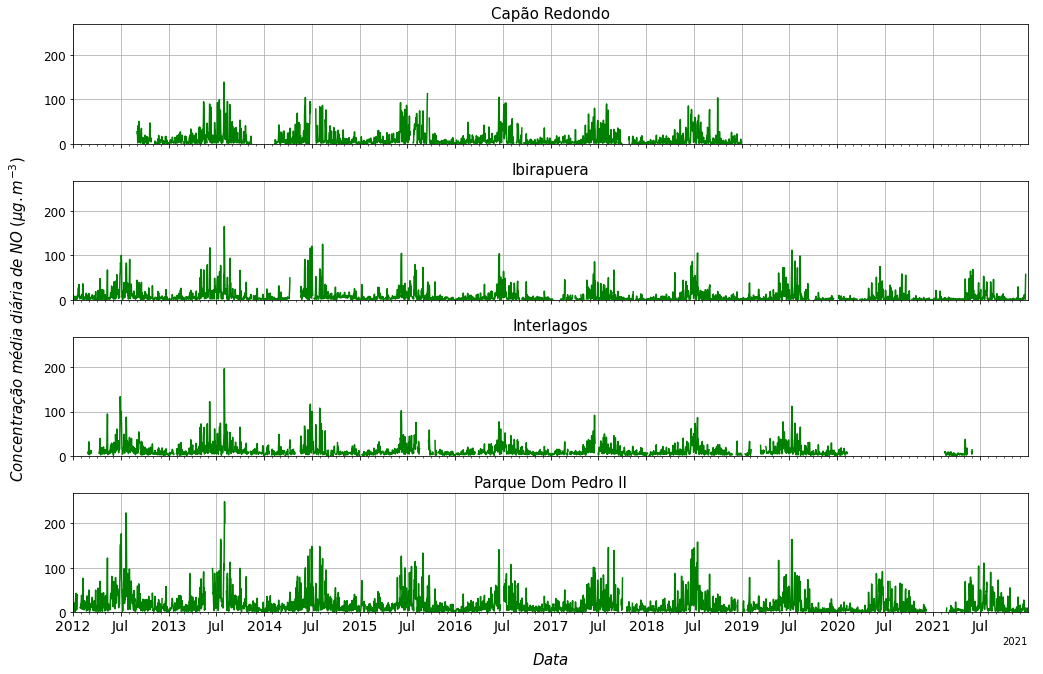

In [213]:
#@title
x_cp_day = cp_day['data_hora']
x_ib_day = ib_day['data_hora']
x_inter_day = inter_day['data_hora']
x_pq_day = pq_day['data_hora']

y_cp_day_no = cp_day['NO']
y_ib_day_no = ib_day['NO']
y_inter_day_no = inter_day['NO']
y_pq_day_no = pq_day['NO']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(15,10)
                                        )

####

ax1.plot(x_cp_day, y_cp_day_no, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_day, y_ib_day_no, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_day, y_inter_day_no, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_day, y_pq_day_no, label='Parque Dom Pedro II', color='green')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_day_no.max(),
         y_ib_day_no.max(),
         y_inter_day_no.max(),
         y_pq_day_no.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;diária\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no_media_diaria.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###NO2

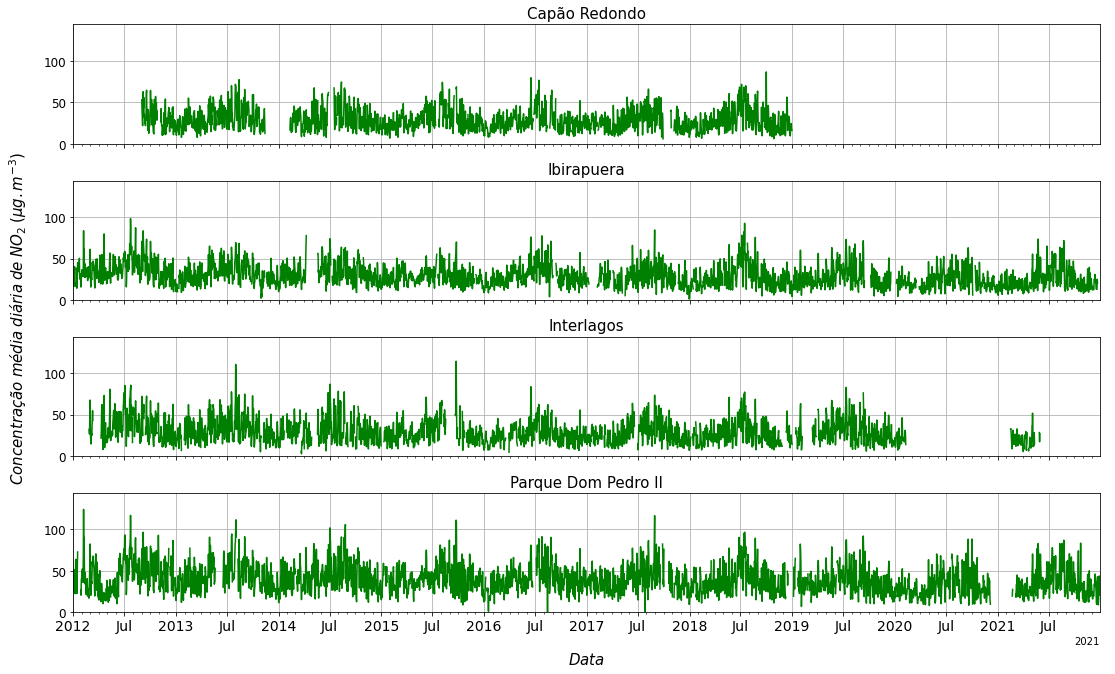

In [214]:
#@title
x_cp_day = cp_day['data_hora']
x_ib_day = ib_day['data_hora']
x_inter_day = inter_day['data_hora']
x_pq_day = pq_day['data_hora']

y_cp_day_no2 = cp_day['NO2']
y_ib_day_no2 = ib_day['NO2']
y_inter_day_no2 = inter_day['NO2']
y_pq_day_no2 = pq_day['NO2']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_day, y_cp_day_no2, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_day, y_ib_day_no2, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_day, y_inter_day_no2, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_day, y_pq_day_no2, label='Parque Dom Pedro II', color='green')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_day_no2.max(),
         y_ib_day_no2.max(),
         y_inter_day_no2.max(),
         y_pq_day_no2.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;diária\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no2_media_diaria.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Monthly Mean Concentration

###O3

####All day long

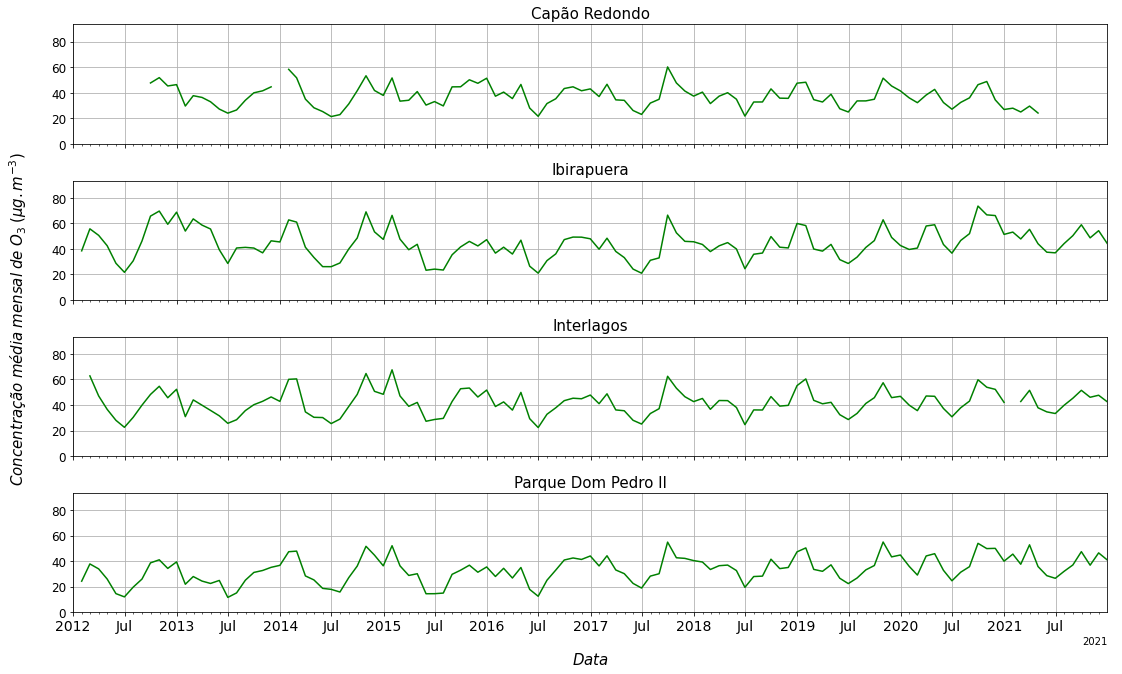

In [215]:
#@title
x_cp_month = cp_month['data_hora']
x_ib_month = ib_month['data_hora']
x_inter_month = inter_month['data_hora']
x_pq_month = pq_month['data_hora']

y_cp_month_o3 = cp_month['O3']
y_ib_month_o3 = ib_month['O3']
y_inter_month_o3 = inter_month['O3']
y_pq_month_o3 = pq_month['O3']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_month, y_cp_month_o3, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_month, y_ib_month_o3, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_month, y_inter_month_o3, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_month, y_pq_month_o3, label='Parque Dom Pedro II', color='green')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_month_o3.max(),
         y_ib_month_o3.max(),
         y_inter_month_o3.max(),
         y_pq_month_o3.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'o3_media_mensal.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####8-hour period by day

###NO

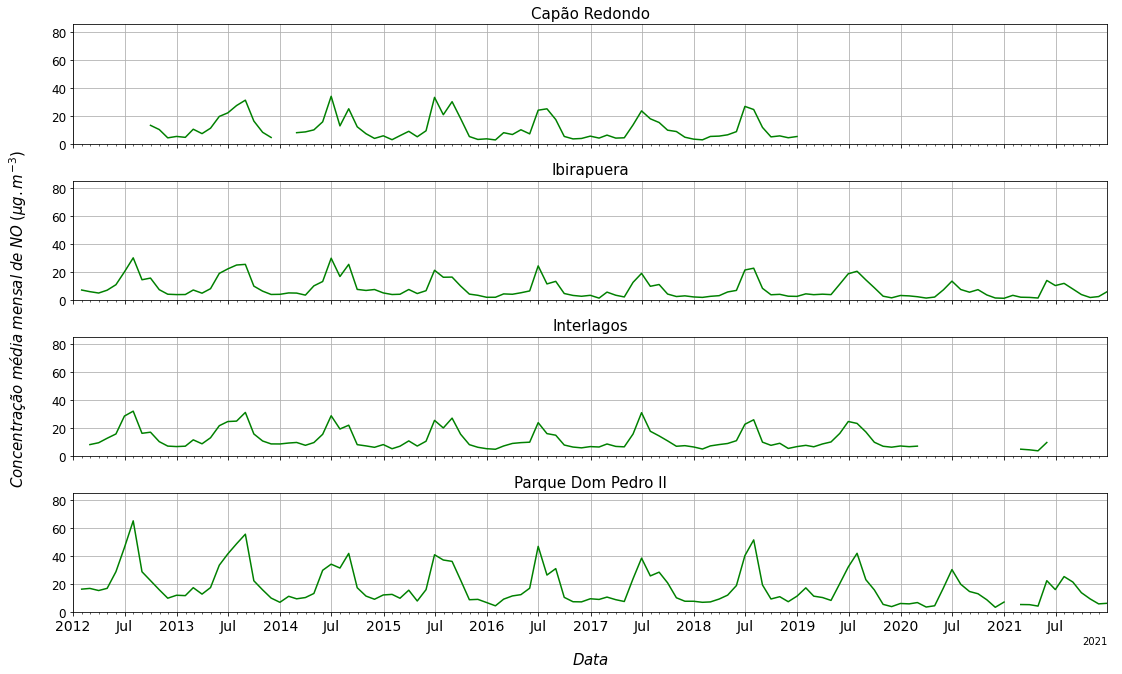

In [216]:
#@title
x_cp_month = cp_month['data_hora']
x_ib_month = ib_month['data_hora']
x_inter_month = inter_month['data_hora']
x_pq_month = pq_month['data_hora']

y_cp_month_no = cp_month['NO']
y_ib_month_no = ib_month['NO']
y_inter_month_no = inter_month['NO']
y_pq_month_no = pq_month['NO']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_month, y_cp_month_no, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_month, y_ib_month_no, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_month, y_inter_month_no, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_month, y_pq_month_no, label='Parque Dom Pedro II', color='green')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_month_no.max(),
         y_ib_month_no.max(),
         y_inter_month_no.max(),
         y_pq_month_no.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no_media_mensal.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###NO2

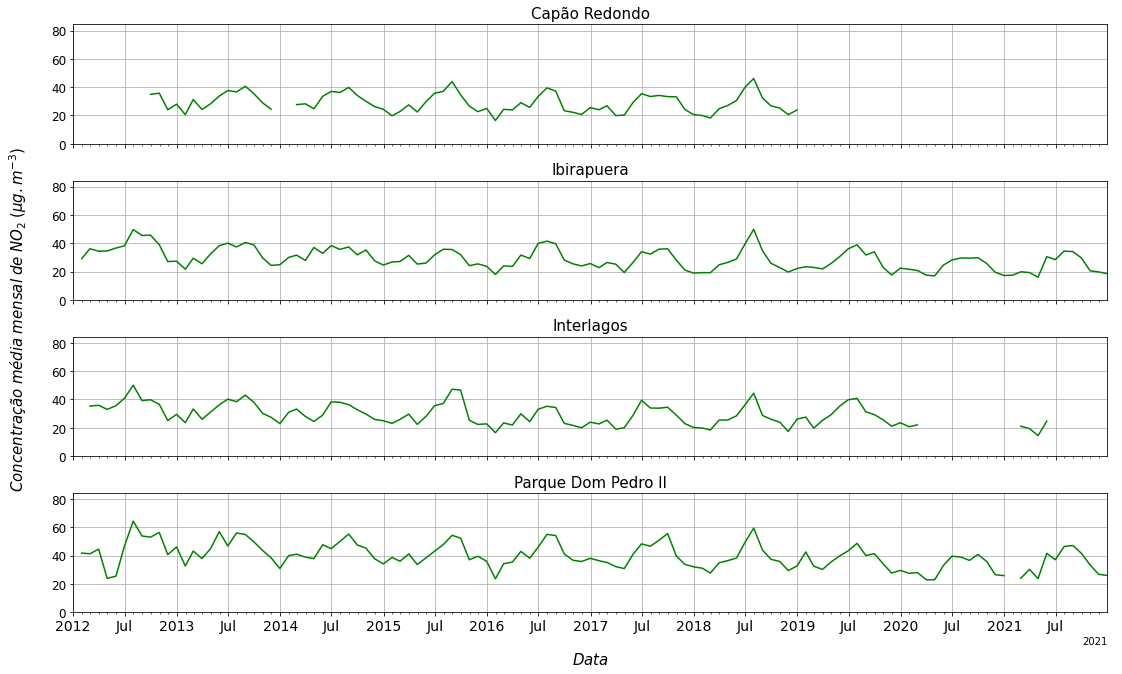

In [217]:
#@title
x_cp_month = cp_month['data_hora']
x_ib_month = ib_month['data_hora']
x_inter_month = inter_month['data_hora']
x_pq_month = pq_month['data_hora']

y_cp_month_no2 = cp_month['NO2']
y_ib_month_no2 = ib_month['NO2']
y_inter_month_no2 = inter_month['NO2']
y_pq_month_no2 = pq_month['NO2']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(x_cp_month, y_cp_month_no2, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(x_ib_month, y_ib_month_no2, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(x_inter_month, y_inter_month_no2, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax4.plot(x_pq_month, y_pq_month_no2, label='Parque Dom Pedro II', color='green')

ax4.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax4.xaxis.set_minor_locator(dates.MonthLocator())

ax4.grid(True)

ax4.set_ylabel(r'')

ax4.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

lim_y = [y_cp_month_no2.max(),
         y_ib_month_no2.max(),
         y_inter_month_no2.max(),
         y_pq_month_no2.max()]

ax1.set_ylim([0, max(lim_y)+20], auto=True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
ax4.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)
# ax4.set_xlabel('')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
plt.ylabel("$Concentração\;média\;mensal\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no2_media_mensal.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Annual Mean Concentration

###O3

####All day long

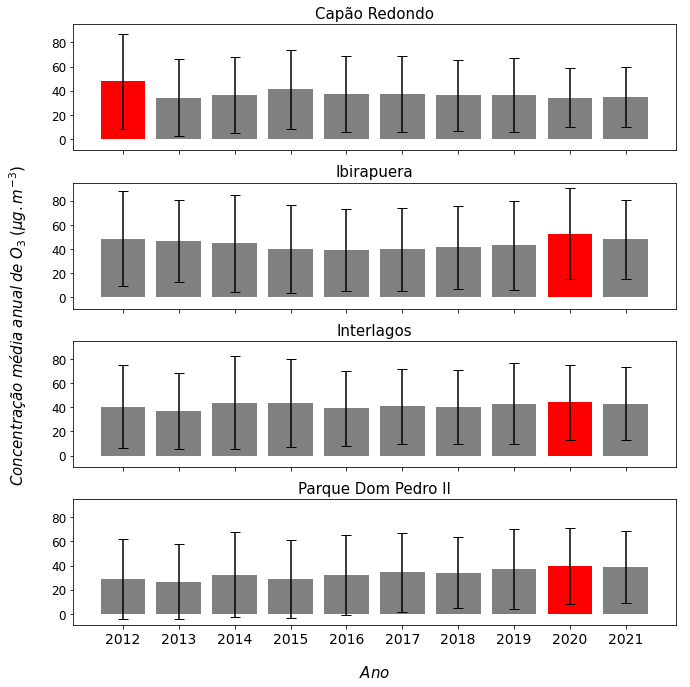

In [218]:
#@title
x_cp_year = cp_year['ano']
x_ib_year = ib_year['ano']
x_inter_year = inter_year['ano']
x_pq_year = pq_year['ano']

y_cp_year_o3 = cp_year['O3']
y_ib_year_o3 = ib_year['O3']
y_inter_year_o3 = inter_year['O3']
y_pq_year_o3 = pq_year['O3']

color_1 = ['r' if (bar == max(y_cp_year_o3)) 
              else 'grey' for bar in y_cp_year_o3]

color_2 = ['r' if (bar == max(y_ib_year_o3)) 
              else 'grey' for bar in y_ib_year_o3]    

color_3 = ['r' if (bar == max(y_inter_year_o3)) 
              else 'grey' for bar in y_inter_year_o3]  

color_4 = ['r' if (bar == max(y_pq_year_o3)) 
              else 'grey' for bar in y_pq_year_o3]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(10,10)
                                        )

ax1.bar(x_cp_year, y_cp_year_o3, label='Capão Redondo', color=color_1,
        yerr=std_cp_year['O3'],ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_o3, label='Ibirapuera', color=color_2,
        yerr=std_ib_year['O3'],ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_o3, label='Interlagos', color=color_3,
        yerr=std_inter_year['O3'],ecolor='black',capsize=5)
ax4.bar(x_pq_year, y_pq_year_o3, label='Parque Dom Pedro II', color=color_4,
        yerr=std_pq_year['O3'],ecolor='black',capsize=5)


# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Ano$",fontsize=15)
plt.ylabel("$Concentração\;média\;anual\;de\;O_{3}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'o3_media_anual.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

In [219]:
#@title
year = list(range(2012,2022))

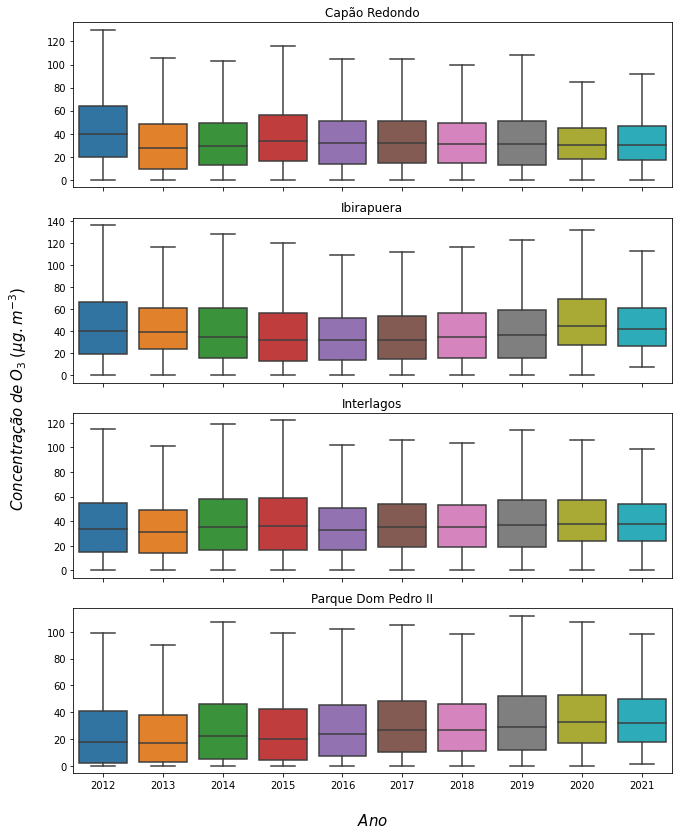

In [220]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='ano', y='O3', 
            showfliers = False, 
            order = year
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='ano', y='O3', 
            showfliers = False, 
            order = year
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)  
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='ano', y='O3', 
            showfliers = False, 
            order = year
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='ano', y='O3', 
            showfliers = False, 
            order = year
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Ano$",fontsize=15)
plt.ylabel("$Concentração\;de\;O_{3}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'o3_boxplot_anual.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####8-hour period by day

#####Boxplot

###NO

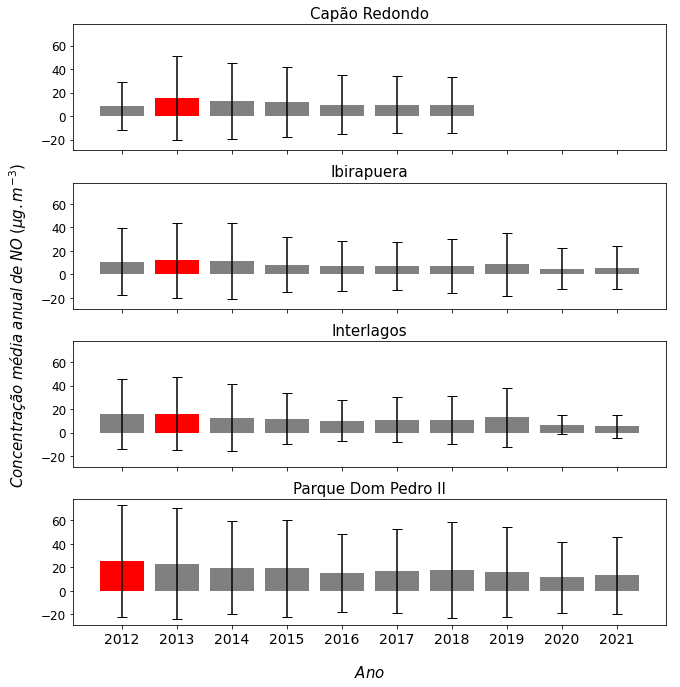

In [221]:
#@title
x_cp_year = cp_year['ano']
x_ib_year = ib_year['ano']
x_inter_year = inter_year['ano']
x_pq_year = pq_year['ano']

y_cp_year_no = cp_year['NO']
y_ib_year_no = ib_year['NO']
y_inter_year_no = inter_year['NO']
y_pq_year_no = pq_year['NO']

color_1 = ['r' if (bar == max(y_cp_year_no)) 
              else 'grey' for bar in y_cp_year_no]

color_2 = ['r' if (bar == max(y_ib_year_no)) 
              else 'grey' for bar in y_ib_year_no]    

color_3 = ['r' if (bar == max(y_inter_year_no)) 
              else 'grey' for bar in y_inter_year_no]  

color_4 = ['r' if (bar == max(y_pq_year_no)) 
              else 'grey' for bar in y_pq_year_no]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(10,10)
                                        )

ax1.bar(x_cp_year, y_cp_year_no, label='Capão Redondo', color=color_1,
        yerr=std_cp_year['NO'],ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no, label='Ibirapuera', color=color_2,
        yerr=std_ib_year['NO'],ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no, label='Interlagos', color=color_3,
        yerr=std_inter_year['NO'],ecolor='black',capsize=5)
ax4.bar(x_pq_year, y_pq_year_no, label='Parque Dom Pedro II', color=color_4,
        yerr=std_pq_year['NO'],ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Ano$",fontsize=15)
plt.ylabel("$Concentração\;média\;anual\;de\;NO\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no_media_anual.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#####Boxplot

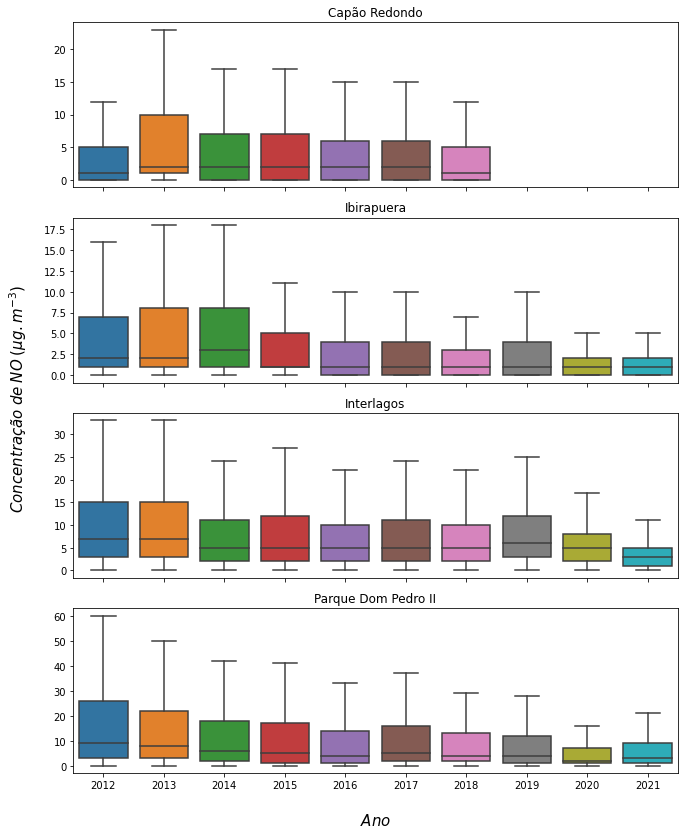

In [222]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='ano', y='NO', 
            showfliers = False, 
            order = year
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='ano', y='NO', 
            showfliers = False, 
            order = year
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)  
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='ano', y='NO', 
            showfliers = False, 
            order = year
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='ano', y='NO', 
            showfliers = False, 
            order = year
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Ano$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no_boxplot_anual.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###NO2

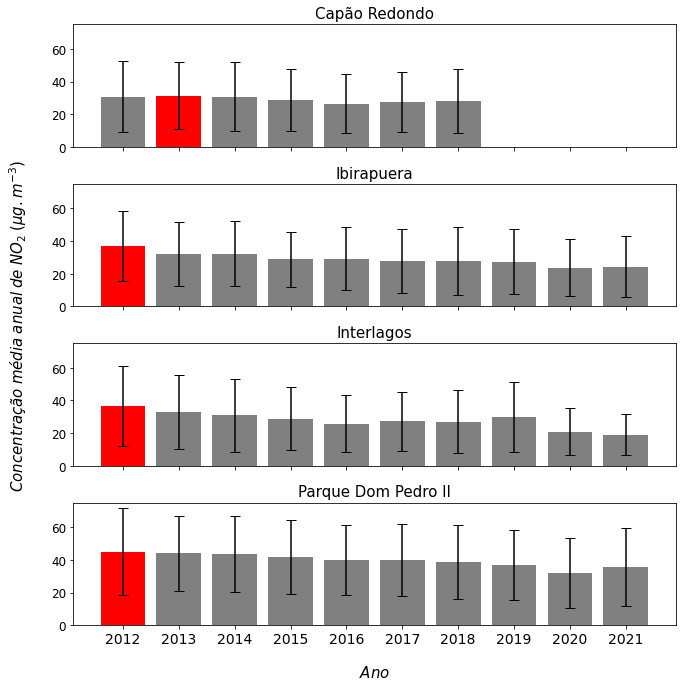

In [223]:
#@title
x_cp_year = cp_year['ano']
x_ib_year = ib_year['ano']
x_inter_year = inter_year['ano']
x_pq_year = pq_year['ano']

y_cp_year_no2 = cp_year['NO2']
y_ib_year_no2 = ib_year['NO2']
y_inter_year_no2 = inter_year['NO2']
y_pq_year_no2 = pq_year['NO2']

color_1 = ['r' if (bar == max(y_cp_year_no2)) 
              else 'grey' for bar in y_cp_year_no2]

color_2 = ['r' if (bar == max(y_ib_year_no2)) 
              else 'grey' for bar in y_ib_year_no2]    

color_3 = ['r' if (bar == max(y_inter_year_no2)) 
              else 'grey' for bar in y_inter_year_no2]  

color_4 = ['r' if (bar == max(y_pq_year_no2)) 
              else 'grey' for bar in y_pq_year_no2]  

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, 
                                         ncols=1, 
                                         sharex=True,
                                         sharey=True, 
                                         figsize=(10,10)
                                        )

ax1.bar(x_cp_year, y_cp_year_no2, label='Capão Redondo', color=color_1,
        yerr=std_cp_year['NO2'],ecolor='black',capsize=5)
ax2.bar(x_ib_year, y_ib_year_no2, label='Ibirapuera', color=color_2,
        yerr=std_ib_year['NO2'],ecolor='black',capsize=5)
ax3.bar(x_inter_year, y_inter_year_no2, label='Interlagos', color=color_3,
        yerr=std_inter_year['NO2'],ecolor='black',capsize=5)
ax4.bar(x_pq_year, y_pq_year_no2, label='Parque Dom Pedro II', color=color_4,
        yerr=std_pq_year['NO2'],ecolor='black',capsize=5)

# ax1.legend()
ax1.set_title('Capão Redondo',fontsize=15)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.grid(True)

# ax2.legend()
ax2.set_title('Ibirapuera',fontsize=15)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.grid(True)

# ax3.legend()
ax3.set_title('Interlagos',fontsize=15)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# ax3.grid(True)

# ax4.legend()
ax4.set_title('Parque Dom Pedro II',fontsize=15)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# ax4.grid(True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Ano$",fontsize=15)
plt.ylabel("$Concentração\;média\;anual\;de\;NO_{2}\;(µg.m^{-3})$\n",fontsize=15)

plt.setp(ax4.get_xticklabels(), 
         fontsize=14
        )

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels(),
          ax4.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'no2_media_anual.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

####Boxplot

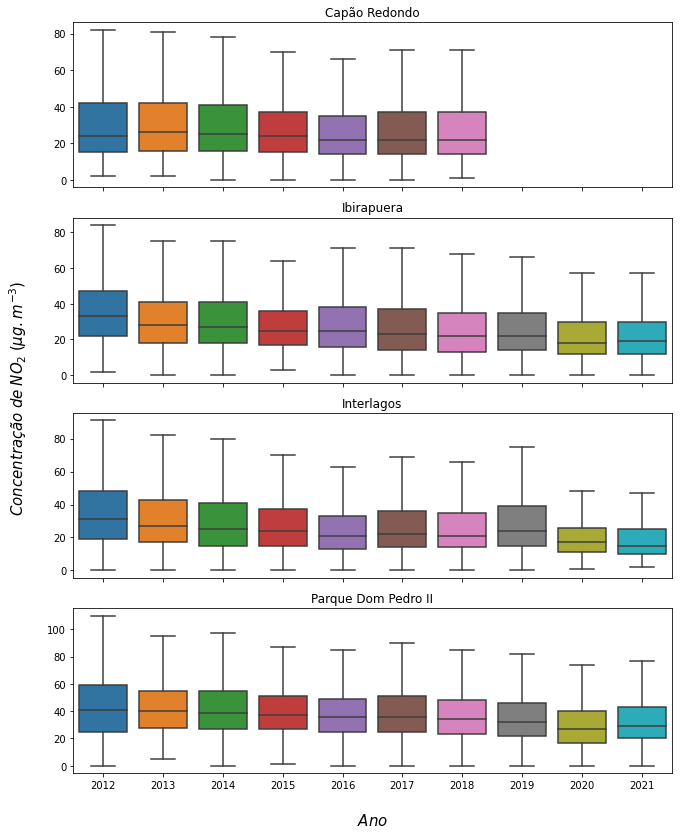

In [224]:
#@title
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# fig.suptitle('Pokemon Stats by Generation')

g1 = sns.boxplot(ax=axes[0], 
            data=df.loc[df.estacao == 'Capão Redondo'], 
            x='ano', y='NO2', 
            showfliers = False, 
            order = year
            )

g1.set(xticklabels=[])  # remove the tick labels
g1.set(title='Capão Redondo')  # add a title
g1.set(xlabel=None)  # remove the axis label
g1.set(ylabel=None)

g2 = sns.boxplot(ax=axes[1], 
            data=df.loc[df.estacao == 'Ibirapuera'], 
            x='ano', y='NO2', 
            showfliers = False, 
            order = year
            )

g2.set(xticklabels=[])  
g2.set(title='Ibirapuera')  
g2.set(xlabel=None)  
g2.set(ylabel=None)

g3 = sns.boxplot(ax=axes[2], 
            data=df.loc[df.estacao == 'Interlagos'], 
            x='ano', y='NO2', 
            showfliers = False, 
            order = year
            )

g3.set(xticklabels=[])  
g3.set(title='Interlagos')  
g3.set(xlabel=None)
g3.set(ylabel=None)

g4 = sns.boxplot(ax=axes[3], 
            data=df.loc[df.estacao == 'Parque Dom Pedro II'], 
            x='ano', y='NO2', 
            showfliers = False, 
            order = year
            )

# g4.set(xticklabels=[])  
g4.set(title='Parque Dom Pedro II')  
g4.set(xlabel=None)
g4.set(ylabel=None)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Ano$",fontsize=15)
plt.ylabel("$Concentração\;de\;NO_{2}\;(µg.m^{-3})\;$\n",fontsize=15)

plt.tight_layout()

plt.savefig(
              dir + 'no2_boxplot_anual.png',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

#Linear Regression

Using Gradient Descent

##Heatmap

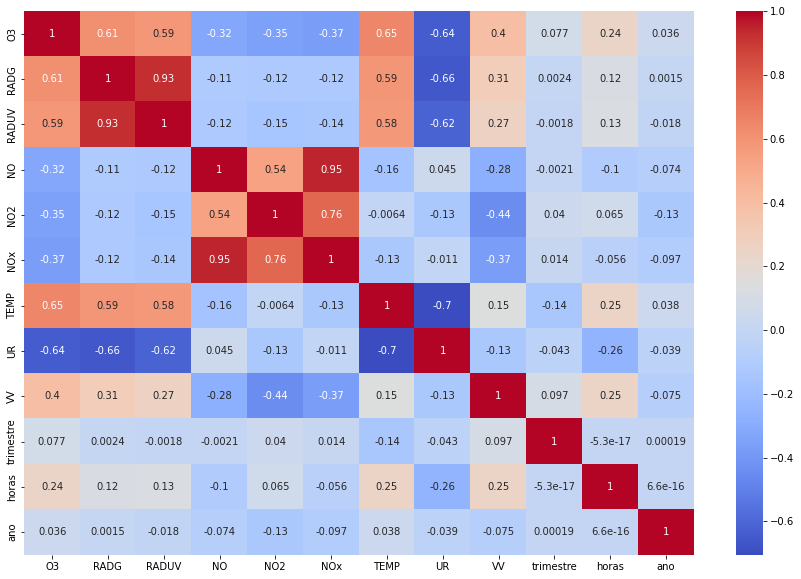

In [225]:
#@title
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),
            cmap='coolwarm',
            annot=True
            );

##Drop rows with nan or inf



In [226]:
#@title
# Changing option context to use infinite as nan
# Drop the rows with nan or infinite values

with pd.option_context('mode.use_inf_as_na', True):
  df.dropna(subset = ['O3', 'NO', 'NO2'], 
          how = 'any', 
          inplace = True
          )

##Simple

Batch Gradient Descent

###Hourly - All day long

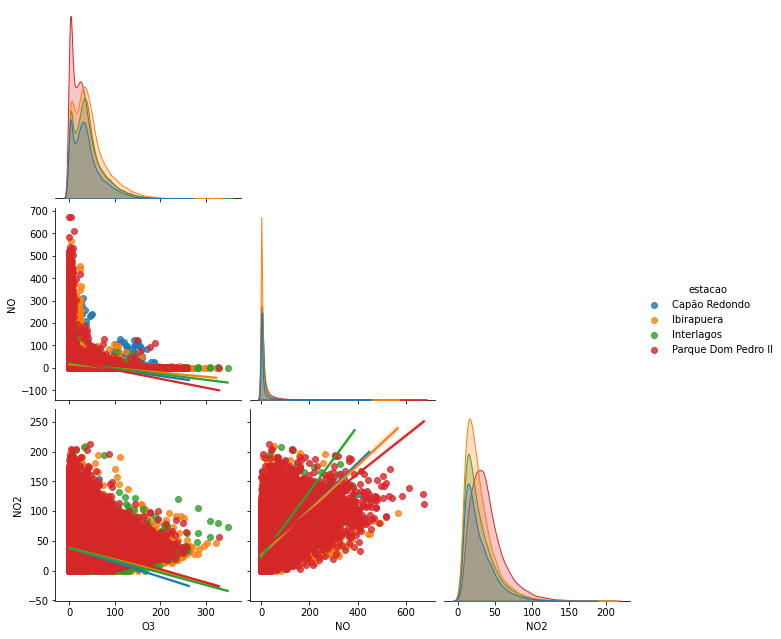

In [227]:
#@title
cols = ['O3', 'NO', 'NO2', 'estacao']

g = sns.pairplot( df[cols], 
              diag_kind = 'kde', 
              kind = 'reg', 
              hue = 'estacao',
              # plot_kws = {'ci': None,
              #             'line_kws':{'color':'black'}},
              height = 3,
              corner = True
            );

###8-hour period by day